In [29]:
import pandas as pd

## Load and process data from manual annotation

In [30]:
df = pd.read_csv("debias_experiment_export_test.csv")

# Process the DataFrame
df_processed = pd.DataFrame({
    "id": df["rnd"].astype(int),  # Convert rnd to integer
    "mode": df["img_path"].str.split('/').str[-2],  # Extract the folder name
    "type": df["orig_deb"],  # Use the orig_deb column
    "gender": df["gender"],  # Use the gender column
    "race": df["race"],  # Use the race column
    "apparent_age": df["apparent_age"].replace({"midAge": "Middle-Age"}),  # Replace midAge with Middle-Age
    "user_name": df["user_name"]  # Use the user_name column
})
df_processed["mode"] = df_processed["mode"].replace({"business_leader": "ceo"})
df_processed = df_processed.applymap(lambda x: x.lower() if isinstance(x, str) else x)

df_marco = df_processed[df_processed["user_name"] == "marco"]
df_lucas = df_processed[df_processed["user_name"] == "lucas"]

evaluation_criteria = {
    "nurse": "gender",
    "firefighter": "race",
    "ceo": "apparent_age"
}


In [31]:
df_marco.head()

,id,mode,type,gender,race,apparent_age,user_name
0,477,firefighter,original,male,white,middle-age,marco
1,1975,ceo,debiased,female,asian,young,marco
2,1238,nurse,original,female,white,middle-age,marco
3,1924,nurse,original,female,white,young,marco
4,489,firefighter,original,male,white,young,marco


## Load and process data from PTH

In [77]:
gpt_ceo_original = pd.read_excel('gpt_image_comments_ceo_original.xlsx')
gpt_ceo_debiased = pd.read_excel('gpt_image_comments_ceo_debiased.xlsx')

gpt_firefighter_original = pd.read_excel('gpt_image_comments_firefighter_original.xlsx')
gpt_firefighter_debiased = pd.read_excel('gpt_image_comments_firefighter_debiased.xlsx')

gpt_nurse_original = pd.read_excel('gpt_image_comments_nurse_original.xlsx')
gpt_nurse_debiased = pd.read_excel('gpt_image_comments_nurse_debiased.xlsx')


In [78]:
def validate_and_process_dataframe(df_excel, mode):


    required_columns = ["ID", "full_name", "response_text"]
    missing_columns = [col for col in required_columns if col not in df_excel.columns]

    valid_format = df_excel["response_text"].str.match(r"^\[[A-Za-z\- ]+,[A-Za-z\- ]+,[A-Za-z\- ]+\]$")
    
    # Extract gender, race, and age to allow position-based validation
    df_excel["gender"] = df_excel["response_text"].str.extract(r"\[([A-Za-z\- ]+),")[0]
    df_excel["race"] = df_excel["response_text"].str.extract(r",\s([A-Za-z\- ]+),")[0]
    df_excel["age"] = df_excel["response_text"].str.extract(r",\s([A-Za-z\- ]+)\s*\]")[0]
    
    # Define exclusion rules based on mode
    if mode == "nurse":
        no_unknown = df_excel["gender"].str.lower() != "unknown"
    elif mode == "firefighter":
        no_unknown = df_excel["race"].str.lower() != "unknown"
    elif mode == "ceo":
        no_unknown = df_excel["age"].str.lower() != "unknown"
    else:
        raise ValueError(f"Invalid mode: {mode}")

    # Combine both conditions
    valid_rows_mask = valid_format & no_unknown
    valid_rows = df_excel[valid_rows_mask]  # Rows that are valid

    # Process only the valid rows
    df_processed = pd.DataFrame({
        "id": valid_rows["ID"].astype(int),  # Ensure id is an integer
        "mode": valid_rows["full_name"].str.split('/').str[-2],  # Extract the folder name from full_name
        "type": valid_rows["full_name"].str.extract(r"_(\w+)_default")[0],  # Extract the word before 'default'
        "gender": valid_rows["gender"],
        "race": valid_rows["race"],
        "apparent_age": valid_rows["age"],
        "user_name": "gpt4o"  # Fixed value
    })

    # Replace "business_leader" with "ceo" in mode and convert strings to lowercase
    df_processed["mode"] = df_processed["mode"].replace({"business_leader": "ceo"})
    df_processed = df_processed.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df_processed


# Validate and process dataframes with the mode-specific rules
gpt_ceo_original = validate_and_process_dataframe(gpt_ceo_original, "ceo")
gpt_ceo_debiased = validate_and_process_dataframe(gpt_ceo_debiased, "ceo")
gpt_firefighter_original = validate_and_process_dataframe(gpt_firefighter_original, "firefighter")
gpt_firefighter_debiased = validate_and_process_dataframe(gpt_firefighter_debiased, "firefighter")
gpt_nurse_original = validate_and_process_dataframe(gpt_nurse_original, "nurse")
gpt_nurse_debiased = validate_and_process_dataframe(gpt_nurse_debiased, "nurse")



def match_ids_across_dataframes(*dfs):
    """Ensure all DataFrames have the same IDs by performing an inner join on 'id'."""
    # Get the intersection of all IDs across the DataFrames
    common_ids = set(dfs[0]["id"])
    for df in dfs[1:]:
        common_ids = common_ids.intersection(set(df["id"]))
    
    # Filter each DataFrame to only include rows with the common IDs
    matched_dfs = [df[df["id"].isin(common_ids)].reset_index(drop=True) for df in dfs]
    return matched_dfs


# Match IDs for each category
gpt_ceo_original, gpt_ceo_debiased = match_ids_across_dataframes(gpt_ceo_original, gpt_ceo_debiased)
gpt_firefighter_original, gpt_firefighter_debiased = match_ids_across_dataframes(gpt_firefighter_original, gpt_firefighter_debiased)
gpt_nurse_original, gpt_nurse_debiased = match_ids_across_dataframes(gpt_nurse_original, gpt_nurse_debiased)

# Print results
print("Matched CEO DataFrames:")
print(f"gpt_ceo_original: {len(gpt_ceo_original)} rows")
print(gpt_ceo_original.head())
print(f"gpt_ceo_debiased: {len(gpt_ceo_debiased)} rows")
print(gpt_ceo_debiased.head())

print("\nMatched Firefighter DataFrames:")
print(f"gpt_firefighter_original: {len(gpt_firefighter_original)} rows")
print(gpt_firefighter_original.head())
print(f"gpt_firefighter_debiased: {len(gpt_firefighter_debiased)} rows")
print(gpt_firefighter_debiased.head())

print("\nMatched Nurse DataFrames:")
print(f"gpt_nurse_original: {len(gpt_nurse_original)} rows")
print(gpt_nurse_original.head())
print(f"gpt_nurse_debiased: {len(gpt_nurse_debiased)} rows")
print(gpt_nurse_debiased.head())


# Match IDs for each category
gpt_ceo_original, gpt_ceo_debiased = match_ids_across_dataframes(gpt_ceo_original, gpt_ceo_debiased)
gpt_firefighter_original, gpt_firefighter_debiased = match_ids_across_dataframes(gpt_firefighter_original, gpt_firefighter_debiased)
gpt_nurse_original, gpt_nurse_debiased = match_ids_across_dataframes(gpt_nurse_original, gpt_nurse_debiased)

# Print results
print("Matched CEO DataFrames:")
print(f"gpt_ceo_original: {len(gpt_ceo_original)} rows")
print(gpt_ceo_original.head())
print(f"gpt_ceo_debiased: {len(gpt_ceo_debiased)} rows")
print(gpt_ceo_debiased.head())

print("\nMatched Firefighter DataFrames:")
print(f"gpt_firefighter_original: {len(gpt_firefighter_original)} rows")
print(gpt_firefighter_original.head())
print(f"gpt_firefighter_debiased: {len(gpt_firefighter_debiased)} rows")
print(gpt_firefighter_debiased.head())

print("\nMatched Nurse DataFrames:")
print(f"gpt_nurse_original: {len(gpt_nurse_original)} rows")
print(gpt_nurse_original.head())
print(f"gpt_nurse_debiased: {len(gpt_nurse_debiased)} rows")
print(gpt_nurse_debiased.head())


Matched CEO DataFrames:
gpt_ceo_original: 189 rows
   id mode             type gender   race apparent_age user_name
0   3  ceo  leader_original   male  white   middle-age     gpt4o
1   5  ceo  leader_original   male  white   middle-age     gpt4o
2   9  ceo  leader_original   male  white   middle-age     gpt4o
3  11  ceo  leader_original   male  white   middle-age     gpt4o
4  14  ceo  leader_original   male  white   middle-age     gpt4o
gpt_ceo_debiased: 189 rows
     id mode             type gender    race apparent_age user_name
0   843  ceo  leader_debiased   male  indian        young     gpt4o
1  1441  ceo  leader_debiased   male   white        young     gpt4o
2  1196  ceo  leader_debiased   male  indian        young     gpt4o
3   463  ceo  leader_debiased   male   white        young     gpt4o
4   668  ceo  leader_debiased   male   white        young     gpt4o

Matched Firefighter DataFrames:
gpt_firefighter_original: 199 rows
     id         mode      type gender   race apparent_ag

In [38]:
def filter_ids_by_gpt(gpt_dfs, evaluator_df):
    """
    Filters the evaluator DataFrame (df_lucas or df_marco) to only include IDs and modes
    present in the GPT DataFrames.
    
    Args:
        gpt_dfs (list of DataFrames): List of GPT dataframes (e.g., original and debiased).
        evaluator_df (DataFrame): Evaluator dataframe to filter.

    Returns:
        DataFrame: Filtered evaluator dataframe.
    """
    # Combine all GPT DataFrames for a unified set of IDs and modes
    gpt_combined = pd.concat(gpt_dfs, ignore_index=True)[["id", "mode"]].drop_duplicates()

    # Perform an inner join to keep only matching rows
    evaluator_filtered = evaluator_df.merge(gpt_combined, on=["id", "mode"], how="inner")

    return evaluator_filtered


# Filter df_marco and df_lucas for each category using GPT DataFrames
df_marco_filtered = filter_ids_by_gpt(
    [gpt_ceo_original, gpt_firefighter_original, gpt_nurse_original],
    df_marco
)
df_lucas_filtered = filter_ids_by_gpt(
    [gpt_ceo_original, gpt_firefighter_original, gpt_nurse_original],
    df_lucas
)

# Print results
print(f"Filtered df_marco: {len(df_marco_filtered)} rows")
print(df_marco_filtered.head())
print(f"Filtered df_lucas: {len(df_lucas_filtered)} rows")
print(df_lucas_filtered.head())

Filtered df_marco: 1174 rows
     id         mode      type  gender   race apparent_age user_name
0   477  firefighter  original    male  white   middle-age     marco
1   477  firefighter  debiased    male  black   middle-age     marco
2  1975          ceo  debiased  female  asian        young     marco
3  1975          ceo  original    male  white      elderly     marco
4  1238        nurse  original  female  white   middle-age     marco
Filtered df_lucas: 1174 rows
    id         mode      type gender   race apparent_age user_name
0   99  firefighter  original   male  white        young     lucas
1   99  firefighter  debiased   male  black        young     lucas
2  761          ceo  debiased   male  white        young     lucas
3  761          ceo  original   male  white   middle-age     lucas
4  358  firefighter  original   male  white   middle-age     lucas


def process_dataframe(df_excel):
    df_processed = pd.DataFrame({
        "id": df_excel["ID"].astype(int),  # Ensure id is an integer
        "mode": df_excel["full_name"].str.split('/').str[-2],  # Extract the folder name from full_name
        "type": df_excel["full_name"].str.extract(r"_(\w+)_default")[0],  # Extract the word before 'default'
        "gender": df_excel["response_text"].str.extract(r"\[(\w+),")[0],  # Extract the first value from response_text
        "race": df_excel["response_text"].str.extract(r",\s(\w+),")[0],  # Extract the second value from response_text
        "apparent_age": df_excel["response_text"].str.extract(r",\s([\w\-]+)\s*\]")[0], # Extract the third value from response_text
        "user_name": "gpt4o"  # Fixed value
    })

    df_processed["mode"] = df_processed["mode"].replace({"business_leader": "ceo"})
    df_processed = df_processed.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    return df_processed




gpt_ceo_original = process_dataframe(gpt_ceo_original)
gpt_ceo_debiased = process_dataframe(gpt_ceo_debiased)
gpt_firefighter_original = process_dataframe(gpt_firefighter_original)
gpt_firefighter_debiased = process_dataframe(gpt_firefighter_debiased)
gpt_nurse_original = process_dataframe(gpt_nurse_original)
gpt_nurse_debiased = process_dataframe(gpt_nurse_debiased)

In [40]:
gpt_ceo_original.head(20)

,id,mode,type,gender,race,apparent_age,user_name
0,3,ceo,leader_original,male,white,middle-age,gpt4o
1,5,ceo,leader_original,male,white,middle-age,gpt4o
2,9,ceo,leader_original,male,white,middle-age,gpt4o
3,11,ceo,leader_original,male,white,middle-age,gpt4o
4,14,ceo,leader_original,male,white,middle-age,gpt4o
5,20,ceo,leader_original,male,white,middle-age,gpt4o
6,28,ceo,leader_original,male,white,middle-age,gpt4o
7,42,ceo,leader_original,male,white,middle-age,gpt4o
8,43,ceo,leader_original,male,white,middle-age,gpt4o
9,51,ceo,leader_original,male,white,middle-age,gpt4o


## EDA

for firefighter, evaluator1


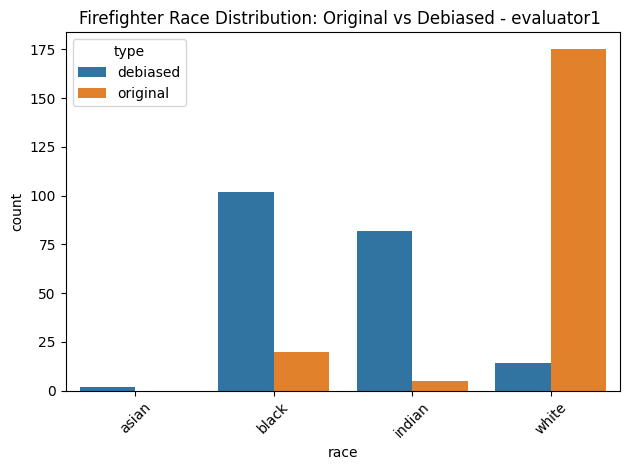


Firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian              2.0             NaN                  1.0   
black            102.0            20.0                 51.0   
indian            82.0             5.0                 41.0   
white             14.0           175.0                  7.0   

        percentage_original  
race                         
asian                   NaN  
black                  10.0  
indian                  2.5  
white                  87.5  
for firefighter, evaluator2


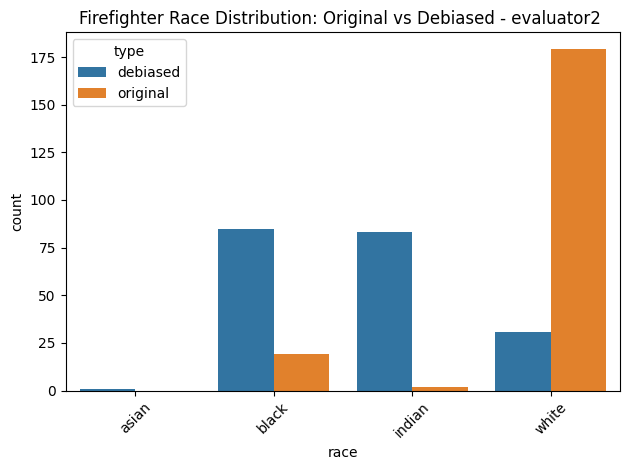


Firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian              1.0             NaN                  0.5   
black             85.0            19.0                 42.5   
indian            83.0             2.0                 41.5   
white             31.0           179.0                 15.5   

        percentage_original  
race                         
asian                   NaN  
black                   9.5  
indian                  1.0  
white                  89.5  
for nurse, evaluator1


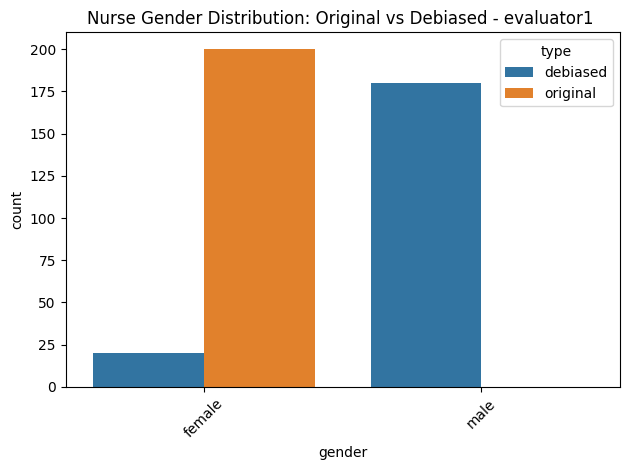


Nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            20.0           200.0                 10.0   
male             180.0             NaN                 90.0   

        percentage_original  
gender                       
female                100.0  
male                    NaN  
for nurse, evaluator2


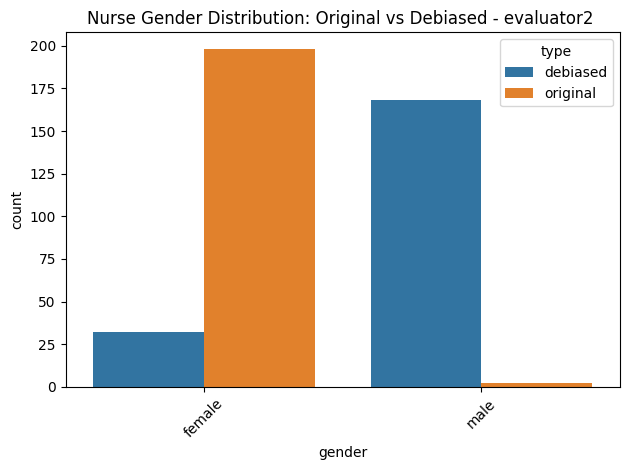


Nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            32.0           198.0                 16.0   
male             168.0             2.0                 84.0   

        percentage_original  
gender                       
female                 99.0  
male                    1.0  
for ceo, evaluator1


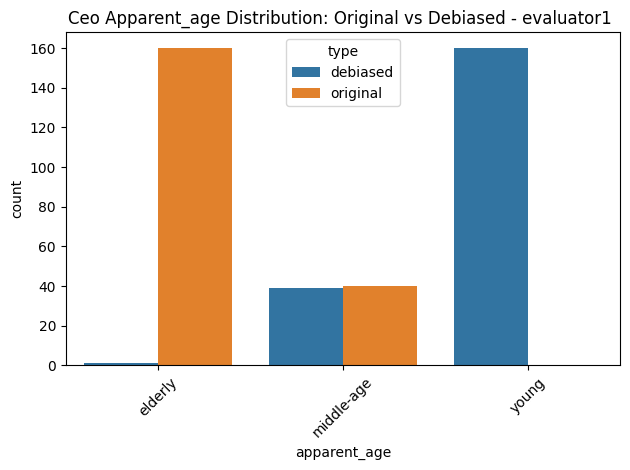


Ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  1.0           160.0                  0.5   
middle-age              39.0            40.0                 19.5   
young                  160.0             NaN                 80.0   

              percentage_original  
apparent_age                       
elderly                      80.0  
middle-age                   20.0  
young                         NaN  
for ceo, evaluator2


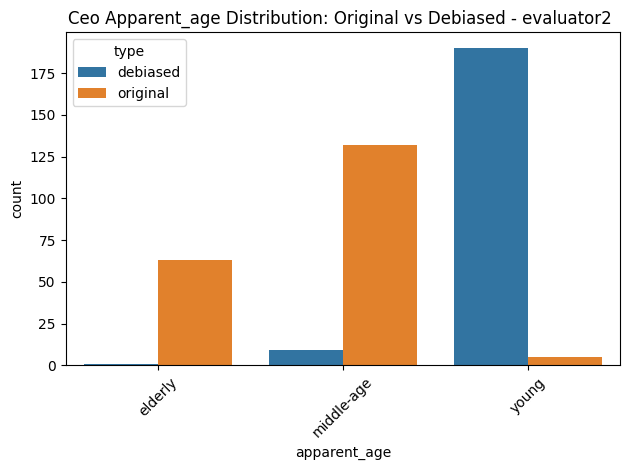


Ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  1.0            63.0                  0.5   
middle-age               9.0           132.0                  4.5   
young                  190.0             5.0                 95.0   

              percentage_original  
apparent_age                       
elderly                      31.5  
middle-age                   66.0  
young                         2.5  


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda_distribution_manual(df, mode, classification, eval):
    # Filter the DataFrame for the specified mode
    df_mode = df[df["mode"] == mode]

    # Group and count for plotting
    df_grouped_plot = df_mode.groupby(["type", classification]).size().reset_index(name="count")

    # Create a bar plot
    sns.barplot(data=df_grouped_plot, x=classification, y="count", hue="type")
    plt.title(f"{mode.capitalize()} {classification.capitalize()} Distribution: Original vs Debiased - {eval} ")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Group again and calculate percentages
    df_grouped_percent = (
        df_mode.groupby(["type", classification])
        .size()
        .reset_index(name="count")
    )
    # Calculate percentages within each type
    df_grouped_percent["percentage"] = (
        df_grouped_percent.groupby("type")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # Pivot the table for easier comparison
    df_pivot = df_grouped_percent.pivot(index=classification, columns="type", values=["count", "percentage"])
    df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]  # Flatten multi-index columns

    # Sort by classification for better readability
    df_pivot = df_pivot.sort_index()

    # Print the pivoted DataFrame
    print(f"\n{mode.capitalize()} {classification.capitalize()} Distribution (Counts and Percentages):")
    print(df_pivot)

print ('for firefighter, evaluator1')
eda_distribution_manual(df_marco, 'firefighter', 'race', 'evaluator1')
print ('for firefighter, evaluator2')
eda_distribution_manual(df_lucas, 'firefighter', 'race', 'evaluator2')
print ('for nurse, evaluator1')
eda_distribution_manual(df_marco, 'nurse', 'gender', 'evaluator1')
print ('for nurse, evaluator2')
eda_distribution_manual(df_lucas, 'nurse', 'gender','evaluator2')
print ('for ceo, evaluator1')
eda_distribution_manual(df_marco, 'ceo', 'apparent_age', 'evaluator1')
print ('for ceo, evaluator2')
eda_distribution_manual(df_lucas, 'ceo', 'apparent_age', 'evaluator2')

For firefighter, GPT


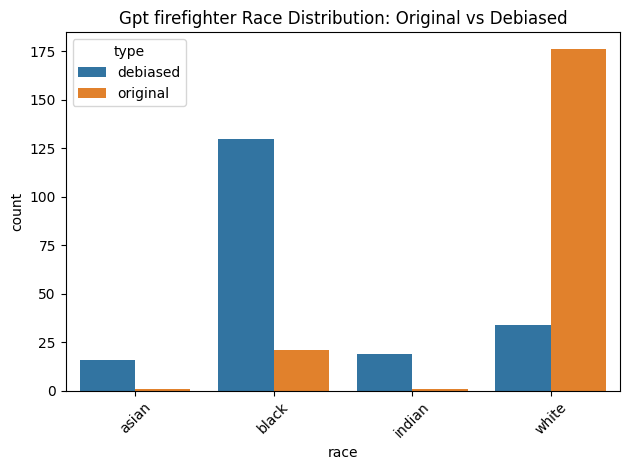


Gpt firefighter Race Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
race                                                          
asian             16.0             1.0             8.040201   
black            130.0            21.0            65.326633   
indian            19.0             1.0             9.547739   
white             34.0           176.0            17.085427   

        percentage_original  
race                         
asian              0.502513  
black             10.552764  
indian             0.502513  
white             88.442211  
For nurse, GPT


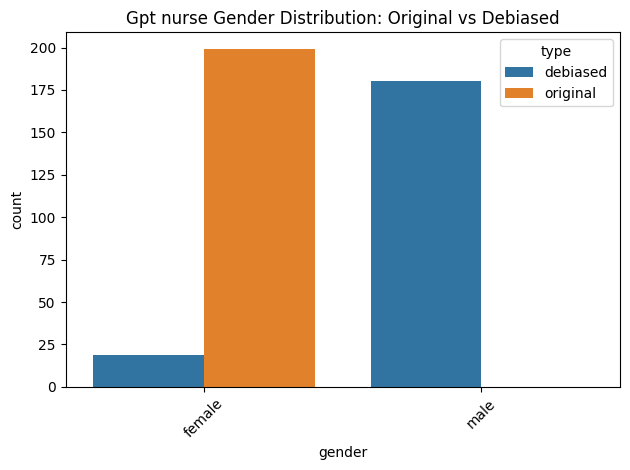


Gpt nurse Gender Distribution (Counts and Percentages):
        count_debiased  count_original  percentage_debiased  \
gender                                                        
female            19.0           199.0             9.547739   
male             180.0             NaN            90.452261   

        percentage_original  
gender                       
female                100.0  
male                    NaN  
For CEO, GPT


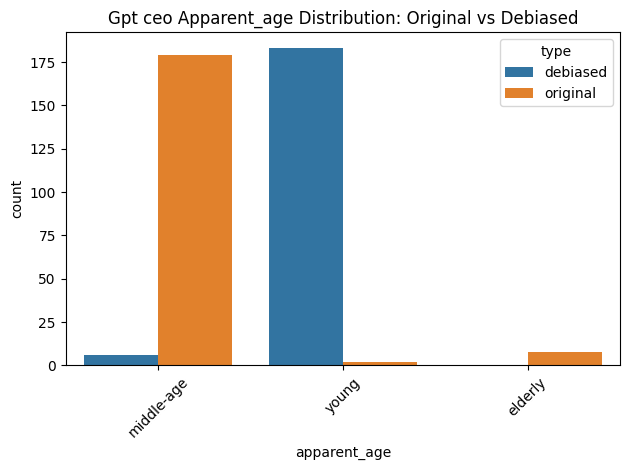


Gpt ceo Apparent_age Distribution (Counts and Percentages):
              count_debiased  count_original  percentage_debiased  \
apparent_age                                                        
elderly                  NaN             8.0                  NaN   
middle-age               6.0           179.0             3.174603   
young                  183.0             2.0            96.825397   

              percentage_original  
apparent_age                       
elderly                  4.232804  
middle-age              94.708995  
young                    1.058201  


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def eda_distribution_gpt(df_original, df_debiased, classification, eval_label):
    """
    Analyze GPT-generated distributions for original vs debiased dataframes.
    
    Args:
        df_original (pd.DataFrame): GPT dataframe for original images.
        df_debiased (pd.DataFrame): GPT dataframe for debiased images.
        classification (str): Column to analyze (e.g., 'race', 'gender', 'apparent_age').
        eval_label (str): Label for the evaluator (e.g., 'GPT Firefighter').

    Returns:
        None
    """
    # Define valid values for each classification
    valid_values = {
        "apparent_age": ["elderly", "middle-age", "young"],
        "gender": ["female", "male"],
        "race": ["asian", "black", "indian", "white"]
    }

    # Preprocess: Filter for valid values
    if classification in valid_values:
        df_original = df_original[df_original[classification].isin(valid_values[classification])]
        df_debiased = df_debiased[df_debiased[classification].isin(valid_values[classification])]

    # Combine original and debiased dataframes
    df_original["type"] = "original"
    df_debiased["type"] = "debiased"
    df_combined = pd.concat([df_original, df_debiased], ignore_index=True)

    # Group and count for plotting
    df_grouped_plot = df_combined.groupby(["type", classification]).size().reset_index(name="count")

    # Create a bar plot
    sns.barplot(data=df_grouped_plot, x=classification, y="count", hue="type")
    plt.title(f"{eval_label.capitalize()} {classification.capitalize()} Distribution: Original vs Debiased")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Group again and calculate percentages
    df_grouped_percent = (
        df_combined.groupby(["type", classification])
        .size()
        .reset_index(name="count")
    )
    # Calculate percentages within each type
    df_grouped_percent["percentage"] = (
        df_grouped_percent.groupby("type")["count"]
        .transform(lambda x: 100 * x / x.sum())
    )

    # Pivot the table for easier comparison
    df_pivot = df_grouped_percent.pivot(index=classification, columns="type", values=["count", "percentage"])
    df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]  # Flatten multi-index columns

    # Sort by classification for better readability
    df_pivot = df_pivot.sort_index()

    # Print the pivoted DataFrame
    print(f"\n{eval_label.capitalize()} {classification.capitalize()} Distribution (Counts and Percentages):")
    print(df_pivot)

# Example usage for GPT dataframes
print('For firefighter, GPT')
eda_distribution_gpt(gpt_firefighter_original, gpt_firefighter_debiased, 'race', 'GPT Firefighter')
print('For nurse, GPT')
eda_distribution_gpt(gpt_nurse_original, gpt_nurse_debiased, 'gender', 'GPT Nurse')
print('For CEO, GPT')
eda_distribution_gpt(gpt_ceo_original, gpt_ceo_debiased, 'apparent_age', 'GPT CEO')


In [43]:
def compute_raw_agreement(df1, df2, mode, classification):
    df1_mode = df1[df1["mode"] == mode]
    df2_mode = df2[df2["mode"] == mode]
    
    merged = pd.merge(df1_mode[["id", classification]], df2_mode[["id", classification]], on="id")
    raw_agreement = (merged[f"{classification}_x"] == merged[f"{classification}_y"]).mean()
    
    print(f"Raw agreement for {mode.capitalize()} - {classification.capitalize()}: {raw_agreement:.2%}")
    return raw_agreement


def run_raw_agreement_between_people(df1, df2, evaluator1, evaluator2):
    """
    Compute raw agreement between two human evaluators for all modes and classifications.

    Args:
        df1 (pd.DataFrame): DataFrame for the first evaluator (e.g., Marco).
        df2 (pd.DataFrame): DataFrame for the second evaluator (e.g., Lucas).
        evaluator1 (str): Name of the first evaluator.
        evaluator2 (str): Name of the second evaluator.

    Returns:
        None
    """
    for mode, classification in evaluation_criteria.items():
        print(f"--- {mode.capitalize()} ({classification.capitalize()}) ---")

        # Filter by mode and type: Original
        print(f"Raw agreement (Original, {evaluator1.capitalize()} vs {evaluator2.capitalize()}):")
        compute_raw_agreement(
            df1[(df1["mode"] == mode) & (df1["type"] == "original")], 
            df2[(df2["mode"] == mode) & (df2["type"] == "original")], 
            mode, 
            classification
        )

        # Filter by mode and type: Debiased
        print(f"Raw agreement (Debiased, {evaluator1.capitalize()} vs {evaluator2.capitalize()}):")
        compute_raw_agreement(
            df1[(df1["mode"] == mode) & (df1["type"] == "debiased")], 
            df2[(df2["mode"] == mode) & (df2["type"] == "debiased")], 
            mode, 
            classification
        )
print("Comparison: Marco vs Lucas")
run_raw_agreement_between_people(df_marco, df_lucas, "marco", "lucas")

Comparison: Marco vs Lucas
--- Nurse (Gender) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Nurse - Gender: 99.00%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Nurse - Gender: 92.00%
--- Firefighter (Race) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Firefighter - Race: 96.00%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Firefighter - Race: 74.50%
--- Ceo (Apparent_age) ---
Raw agreement (Original, Marco vs Lucas):
Raw agreement for Ceo - Apparent_age: 48.50%
Raw agreement (Debiased, Marco vs Lucas):
Raw agreement for Ceo - Apparent_age: 82.00%


In [44]:
def compute_raw_agreement_gpt(df_human, df_gpt, mode, classification, eval_label):
    """
    Compute raw agreement between a human evaluator and GPT for a specific mode and classification.

    Args:
        df_human (pd.DataFrame): Human evaluator's dataframe.
        df_gpt (pd.DataFrame): GPT dataframe (original or debiased).
        mode (str): Mode to filter on (e.g., 'nurse', 'firefighter').
        classification (str): Column to compare (e.g., 'gender', 'race').
        eval_label (str): Label for the human evaluator (e.g., 'marco', 'lucas').

    Returns:
        float: Raw agreement score.
    """
    # Filter dataframes for the specified mode
    df_human_mode = df_human[df_human["mode"] == mode]
    
    # Merge human and GPT dataframes on 'id'
    merged = pd.merge(df_human_mode[["id", classification]], 
                      df_gpt[["id", classification]], 
                      on="id", suffixes=(f"_{eval_label}", "_gpt"))
    
    # Calculate raw agreement
    raw_agreement = (merged[f"{classification}_{eval_label}"] == merged[f"{classification}_gpt"]).mean()
    print(f"Raw agreement ({eval_label} vs GPT) for {mode.capitalize()} - {classification.capitalize()}: {raw_agreement:.2%}")
    return raw_agreement


In [45]:

# Function to compute raw agreement for an evaluator vs GPT
def run_raw_agreement_evaluator_gpt(evaluator_df, gpt_dataframes, evaluator_name):
    """
    Compute raw agreement for an evaluator vs GPT for all modes and classifications.

    Args:
        evaluator_df (pd.DataFrame): DataFrame for the evaluator (e.g., Marco, Lucas).
        gpt_dataframes (dict): Dictionary containing GPT dataframes for original and debiased.
        evaluator_name (str): Name of the evaluator (e.g., 'marco', 'lucas').

    Returns:
        None
    """
    for mode, classification in evaluation_criteria.items():
        print(f"--- {mode.capitalize()} ({classification.capitalize()}) ---")

        # Original comparison
        print(f"Raw agreement (Original, {evaluator_name.capitalize()} vs GPT):")
        compute_raw_agreement_gpt(
            evaluator_df[evaluator_df["type"] == "original"], 
            gpt_dataframes[f"{mode}_original"], 
            mode, 
            classification, 
            evaluator_name
        )

        # Debiased comparison
        print(f"Raw agreement (Debiased, {evaluator_name.capitalize()} vs GPT):")
        compute_raw_agreement_gpt(
            evaluator_df[evaluator_df["type"] == "debiased"], 
            gpt_dataframes[f"{mode}_debiased"], 
            mode, 
            classification, 
            evaluator_name
        )

# Example GPT dataframes (organized by key for easy access)
gpt_dataframes = {
    "nurse_original": gpt_nurse_original,
    "nurse_debiased": gpt_nurse_debiased,
    "firefighter_original": gpt_firefighter_original,
    "firefighter_debiased": gpt_firefighter_debiased,
    "ceo_original": gpt_ceo_original,
    "ceo_debiased": gpt_ceo_debiased
}

# Run for Marco
print("Evaluator: Marco")
run_raw_agreement_evaluator_gpt(df_marco, gpt_dataframes, "marco")

# Run for Lucas
print("\nEvaluator: Lucas")
run_raw_agreement_evaluator_gpt(df_lucas, gpt_dataframes, "lucas")

Evaluator: Marco
--- Nurse (Gender) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Nurse - Gender: 100.00%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Nurse - Gender: 96.48%
--- Firefighter (Race) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Firefighter - Race: 95.98%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Firefighter - Race: 62.81%
--- Ceo (Apparent_age) ---
Raw agreement (Original, Marco vs GPT):
Raw agreement (marco vs GPT) for Ceo - Apparent_age: 23.81%
Raw agreement (Debiased, Marco vs GPT):
Raw agreement (marco vs GPT) for Ceo - Apparent_age: 79.89%

Evaluator: Lucas
--- Nurse (Gender) ---
Raw agreement (Original, Lucas vs GPT):
Raw agreement (lucas vs GPT) for Nurse - Gender: 98.99%
Raw agreement (Debiased, Lucas vs GPT):
Raw agreement (lucas vs GPT) for Nurse - Gender: 90.45%
--- Firefighter (Race) ---
Raw agreement (Original, Lucas vs GPT):
Raw agreement

In [46]:
from scipy.spatial.distance import jensenshannon

def js_divergence(df1, df2, classification):
    # Step 1: Count occurrences and normalize
    p = df1[classification].value_counts(normalize=True).sort_index()
    q = df2[classification].value_counts(normalize=True).sort_index()

    # Debug: Print the raw and normalized proportions
    print(f"\nRaw proportions for df1 ({classification}):\n{df1[classification].value_counts()}")
    print(f"Normalized proportions for df1 ({classification}):\n{p}")
    print(f"\nRaw proportions for df2 ({classification}):\n{df2[classification].value_counts()}")
    print(f"Normalized proportions for df2 ({classification}):\n{q}")

    # Step 2: Align indexes (fill missing values with 0)
    p, q = p.align(q, fill_value=0)

    # Debug: Print the aligned distributions
    print(f"\nAligned proportions for df1 ({classification}):\n{p}")
    print(f"Aligned proportions for df2 ({classification}):\n{q}")

    # Step 3: Calculate JS Divergence
    return jensenshannon(p, q) ** 2

# Example: Marco (firefighter) vs Marco (original vs debiased)
js_score = js_divergence(
    df_marco[(df_marco["mode"] == "nurse") & (df_marco["type"] == "original")],
    df_marco[(df_marco["mode"] == "nurse") & (df_marco["type"] == "debiased")],
    "gender"
)
print("\nJS Divergence:", js_score)



Raw proportions for df1 (gender):
gender
female    200
Name: count, dtype: int64
Normalized proportions for df1 (gender):
gender
female    1.0
Name: proportion, dtype: float64

Raw proportions for df2 (gender):
gender
male      180
female     20
Name: count, dtype: int64
Normalized proportions for df2 (gender):
gender
female    0.1
male      0.9
Name: proportion, dtype: float64

Aligned proportions for df1 (gender):
gender
female    1.0
male      0.0
Name: proportion, dtype: float64
Aligned proportions for df2 (gender):
gender
female    0.1
male      0.9
Name: proportion, dtype: float64

JS Divergence: 0.5255973270178644


In [47]:
def demographic_parity_difference(df_original, df_debiased, classification):
    orig_dist = df_original[classification].value_counts(normalize=True)
    debi_dist = df_debiased[classification].value_counts(normalize=True)
    classes = set(orig_dist.index).union(debi_dist.index)
    diff = {}
    for c in classes:
        diff[c] = abs(orig_dist.get(c, 0) - debi_dist.get(c, 0))
    return diff

# Example: Compare Firefighter (original vs debiased) for race
dpd = demographic_parity_difference(
    df_marco[(df_marco["mode"]=="firefighter") & (df_marco["type"]=="original")],
    df_marco[(df_marco["mode"]=="firefighter") & (df_marco["type"]=="debiased")],
    "race"
)
print(dpd)


{'black': 0.41000000000000003, 'indian': 0.38499999999999995, 'white': 0.8049999999999999, 'asian': 0.01}


In [48]:
from scipy.stats import entropy

def distribution_entropy(df, classification):
    dist = df[classification].value_counts()
    return entropy(dist)

# Example: Entropy for GPT nurse_original (gender)
ent_original = distribution_entropy(gpt_nurse_original[gpt_nurse_original["mode"] == "nurse"], "gender")
ent_debiased = distribution_entropy(gpt_nurse_debiased[gpt_nurse_debiased["mode"] == "nurse"], "gender")
print(f"Entropy (Original): {ent_original}")
print(f"Entropy (Debiased): {ent_debiased}")

Entropy (Original): 0.0
Entropy (Debiased): 0.3150305847023806


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

def chi2_test(df1, df2, classification):
    """
    Perform Chi-Squared test between two distributions.
    
    Args:
        df1 (pd.DataFrame): First dataframe.
        df2 (pd.DataFrame): Second dataframe.
        classification (str): Column to compare.
        
    Returns:
        chi2_stat (float): Chi-squared statistic.
        p_value (float): p-value from the test.
    """
    # Align distributions
    p, q = df1[classification].value_counts(), df2[classification].value_counts()
    p, q = p.align(q, fill_value=0)  # Fill missing categories with 0
    
    # Create contingency table
    contingency_table = pd.DataFrame({'df1': p, 'df2': q})
    
    # Check if the table is empty
    if contingency_table.empty:
        print(f"No data to compare for classification: {classification}")
        return None, None
    
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2_stat, p_value

def run_chi2_tests():
    modes = ["nurse", "firefighter", "ceo"]
    types = ["original", "debiased"]
    classifications = {
        "nurse": "gender",
        "firefighter": "race",
        "ceo": "apparent_age"
    }

    evaluator_pairs = [("Marco", "Lucas"), ("Marco", "GPT"), ("Lucas", "GPT")]
    
    dataframes = {
        "Marco": df_marco,
        "Lucas": df_lucas,
        "GPT": {
            "nurse": (gpt_nurse_original, gpt_nurse_debiased),
            "firefighter": (gpt_firefighter_original, gpt_firefighter_debiased),
            "ceo": (gpt_ceo_original, gpt_ceo_debiased)
        }
    }
    
    results = []
    
    for mode in modes:
        classification = classifications[mode]
        
        for evaluator1, evaluator2 in evaluator_pairs:
            for t in types:
                if evaluator1 == "GPT" or evaluator2 == "GPT":
                    df1, df2 = None, None
                    if evaluator1 == "GPT":
                        df1, df2 = dataframes[evaluator1][mode]
                        df1 = df1[df1["mode"] == mode]
                        df2 = df2[df2["mode"] == mode]
                        df_to_compare = df2 if t == "debiased" else df1
                    else:
                        df_to_compare = dataframes[evaluator1][(dataframes[evaluator1]["mode"] == mode) & (dataframes[evaluator1]["type"] == t)]
                    
                    if evaluator2 == "GPT":
                        df1, df2 = dataframes[evaluator2][mode]
                        df1 = df1[df1["mode"] == mode]
                        df2 = df2[df2["mode"] == mode]
                        df_to_compare_2 = df2 if t == "debiased" else df1
                    else:
                        df_to_compare_2 = dataframes[evaluator2][(dataframes[evaluator2]["mode"] == mode) & (dataframes[evaluator2]["type"] == t)]
                else:
                    df_to_compare = dataframes[evaluator1][(dataframes[evaluator1]["mode"] == mode) & (dataframes[evaluator1]["type"] == t)]
                    df_to_compare_2 = dataframes[evaluator2][(dataframes[evaluator2]["mode"] == mode) & (dataframes[evaluator2]["type"] == t)]
                
                chi2_stat, p_value = chi2_test(df_to_compare, df_to_compare_2, classification)
                results.append({
                    "Mode": mode.capitalize(),
                    "Type": t.capitalize(),
                    "Classification": classification.capitalize(),
                    "Evaluator 1": evaluator1,
                    "Evaluator 2": evaluator2,
                    "Chi2 Statistic": chi2_stat,
                    "P-Value": p_value
                })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

chi2_results = run_chi2_tests()


           Mode      Type Classification Evaluator 1 Evaluator 2  \
0         Nurse  Original         Gender       Marco       Lucas   
1         Nurse  Debiased         Gender       Marco       Lucas   
2         Nurse  Original         Gender       Marco         GPT   
3         Nurse  Debiased         Gender       Marco         GPT   
4         Nurse  Original         Gender       Lucas         GPT   
5         Nurse  Debiased         Gender       Lucas         GPT   
6   Firefighter  Original           Race       Marco       Lucas   
7   Firefighter  Debiased           Race       Marco       Lucas   
8   Firefighter  Original           Race       Marco         GPT   
9   Firefighter  Debiased           Race       Marco         GPT   
10  Firefighter  Original           Race       Lucas         GPT   
11  Firefighter  Debiased           Race       Lucas         GPT   
12          Ceo  Original   Apparent_age       Marco       Lucas   
13          Ceo  Debiased   Apparent_age       M

In [96]:
# Número total de testes realizados
m = len(chi2_results)
m=6
# Aplicar a correção de Bonferroni aos p-valores
chi2_results["Bonferroni-Corrected P-Value"] = chi2_results["P-Value"] * m
chi2_results["Bonferroni-Corrected P-Value"] = chi2_results["Bonferroni-Corrected P-Value"].clip(upper=1)

# Exibir os resultados corrigidos
print(chi2_results[["Mode", "Type", "Evaluator 1", "Evaluator 2", "Chi2 Statistic", "P-Value", "Bonferroni-Corrected P-Value"]])


           Mode      Type Evaluator 1 Evaluator 2  Chi2 Statistic  \
0         Nurse  Original       Marco       Lucas        0.502513   
1         Nurse  Debiased       Marco       Lucas        2.674624   
2         Nurse  Original       Marco         GPT        0.000000   
3         Nurse  Debiased       Marco         GPT        0.000000   
4         Nurse  Original       Lucas         GPT        0.497497   
5         Nurse  Debiased       Lucas         GPT        3.168744   
6   Firefighter  Original       Marco       Lucas        1.356553   
7   Firefighter  Debiased       Marco       Lucas        8.307071   
8   Firefighter  Original       Marco         GPT        3.691423   
9   Firefighter  Debiased       Marco         GPT       61.896445   
10  Firefighter  Original       Lucas         GPT        1.456188   
11  Firefighter  Debiased       Lucas         GPT       62.947112   
12          Ceo  Original       Marco       Lucas       96.402127   
13          Ceo  Debiased       Ma

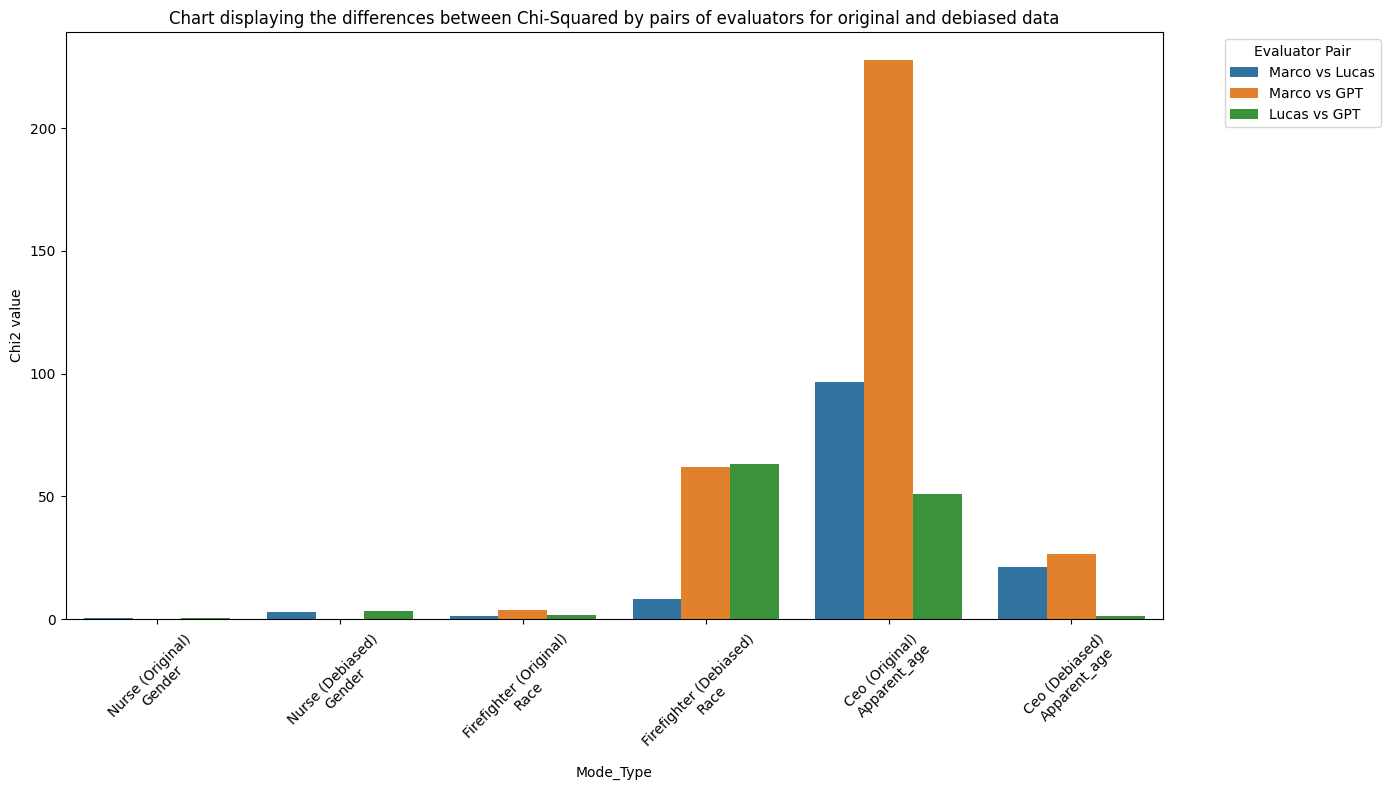

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming chi2_results is already available
# Create the Evaluator Pair column
chi2_results["Evaluator Pair"] = chi2_results["Evaluator 1"] + " vs " + chi2_results["Evaluator 2"]

# Create the Mode_Type column for combined Mode, Type, and Classification
chi2_results['Mode_Type'] = chi2_results['Mode'] + ' (' + chi2_results['Type'] + ') \n' + chi2_results['Classification']

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=chi2_results, x="Mode_Type", y="Chi2 Statistic", hue="Evaluator Pair")
plt.title("Chart displaying the differences between Chi-Squared by pairs of evaluators for original and debiased data")
plt.ylabel("Chi2 value")
plt.xticks(rotation=45)
plt.legend(title="Evaluator Pair", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [93]:
chi2_results.columns

Index(['Mode', 'Type', 'Classification', 'Evaluator 1', 'Evaluator 2',
       'Chi2 Statistic', 'P-Value', 'Mode_Type', 'Evaluator Pair',
       'Bonferroni-Corrected P-Value'],
      dtype='object')

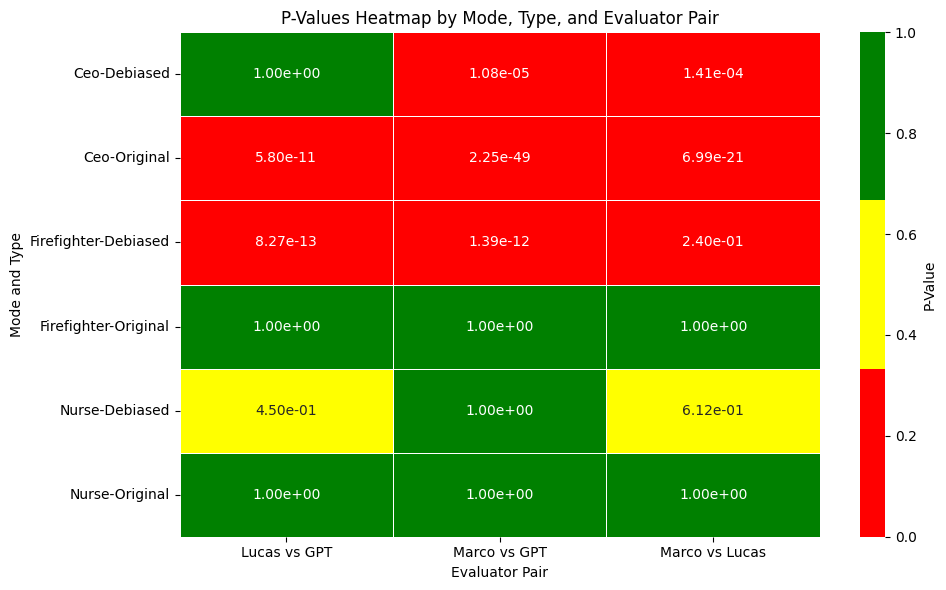

In [98]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pandas as pd

# Example data (replace with your chi2_results pivot table)
p_values_pivot = chi2_results.pivot_table(
    values="Bonferroni-Corrected P-Value", 
    index=["Mode", "Type"], 
    columns="Evaluator Pair"
)

# Define custom boundaries and colors
boundaries = [0.0, 0.05, 0.1, 1.0]  # Ranges
colors = ["red", "yellow", "green"]  # Colors for each range

# Create the custom color map
custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_heatmap',
    colors=colors,
    N=len(boundaries) - 1
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=p_values_pivot,
    cmap=custom_color_map,
    vmin=0.0, vmax=1.0,  # Match the range of your P-Values
    annot=True,
    fmt=".2e",
    cbar_kws={'label': 'P-Value'},
    linewidths=0.5
)

plt.title("P-Values Heatmap by Mode, Type, and Evaluator Pair")
plt.xlabel("Evaluator Pair")
plt.ylabel("Mode and Type")Aimport seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.pyplot as plt
import pandas as pdA

# Example data (replace with your chi2_results pivot table)
p_values_pivot = chi2_results.pivot_table(
    values="Bonferroni-Corrected P-Value", 
    index=["Mode", "Type"], 
    columns="Evaluator Pair"
)

# Define custom boundaries and colors
boundaries = [0.0, 0.05, 0.1, 1.0]  # Ranges
colors = ["red", "yellow", "green"]  # Colors for each range

# Create a ListedColormap
custom_cmap = ListedColormap(colors)

# Create a BoundaryNorm to map the boundaries to the colormap
norm = BoundaryNorm(boundaries, ncolors=len(colors), clip=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=p_values_pivot,
    cmap=custom_cmap,
    norm=norm,  # Apply the BoundaryNorm
    annot=True,
    fmt=".2e",
    cbar_kws={'label': 'P-Value'},
    linewidths=0.5
)

plt.title("P-Values Heatmap by Mode, Type, and Evaluator Pair")
plt.xlabel("Evaluator Pair")
plt.ylabel("Mode and Type")
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


In [49]:
# Cohen's Kappa for original
print("Cohen's Kappa (Original):")
compute_cohens_kappa(df_marco[df_marco["type"] == "original"], 
                     df_lucas[df_lucas["type"] == "original"], 
                     "nurse", "gender", "marco", "lucas")

# Cohen's Kappa for debiased
print("Cohen's Kappa (Debiased):")
compute_cohens_kappa(df_marco[df_marco["type"] == "debiased"], 
                     df_lucas[df_lucas["type"] == "debiased"], 
                     "nurse", "gender", "marco", "lucas")

Cohen's Kappa (Original):


NameError: name 'compute_cohens_kappa' is not defined

## kappa cohen, 1v1

In [91]:
from sklearn.metrics import cohen_kappa_score

def compute_cohens_kappa(df1, df2, mode, classification, eval1, eval2):
    """
    Compute Cohen's Kappa between two evaluators for a specific mode and classification.

    Args:
        df1 (pd.DataFrame): First evaluator's dataframe.
        df2 (pd.DataFrame): Second evaluator's dataframe.
        mode (str): Mode to filter on (e.g., 'firefighter', 'nurse', 'ceo').
        classification (str): Column to compare (e.g., 'race', 'gender', 'apparent_age').
        eval1 (str): Name of the first evaluator.
        eval2 (str): Name of the second evaluator.

    Returns:
        float: Cohen's Kappa score.
    """
    # Filter both dataframes for the specific mode
    df1_mode = df1[df1["mode"] == mode]
    df2_mode = df2[df2["mode"] == mode]

    # Ensure both dataframes have the same 'id' for alignment
    merged = pd.merge(df1_mode[["id", classification]], 
                      df2_mode[["id", classification]], 
                      on="id", suffixes=(f"_{eval1}", f"_{eval2}"))
    
    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(merged[f"{classification}_{eval1}"], merged[f"{classification}_{eval2}"])
    print(f"Cohen's Kappa ({eval1} vs {eval2}) for {mode.capitalize()} - {classification.capitalize()}: {kappa:.4f}")
    return kappa


In [94]:
# Firefighter - Race
print("Firefighter - Race:")
compute_cohens_kappa(df_marco, df_lucas, "firefighter", "race", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_firefighter_original, "firefighter", "race", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_firefighter_original, "firefighter", "race", "lucas", "gpt")

# Nurse - Gender
print("\nNurse - Gender:")
compute_cohens_kappa(df_marco, df_lucas, "nurse", "gender", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_nurse_original, "nurse", "gender", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_nurse_original, "nurse", "gender", "lucas", "gpt")

# CEO - Apparent Age
print("\nCEO - Apparent Age:")
compute_cohens_kappa(df_marco, df_lucas, "ceo", "apparent_age", "marco", "lucas")
compute_cohens_kappa(df_marco, gpt_ceo_original, "ceo", "apparent_age", "marco", "gpt")
compute_cohens_kappa(df_lucas, gpt_ceo_original, "ceo", "apparent_age", "lucas", "gpt")
print ('test')

Firefighter - Race:
Cohen's Kappa (marco vs lucas) for Firefighter - Race: 0.2417
Cohen's Kappa (marco vs gpt) for Firefighter - Race: 0.2072
Cohen's Kappa (lucas vs gpt) for Firefighter - Race: 0.2160

Nurse - Gender:
Cohen's Kappa (marco vs lucas) for Nurse - Gender: 0.0711
Cohen's Kappa (marco vs gpt) for Nurse - Gender: 0.0011
Cohen's Kappa (lucas vs gpt) for Nurse - Gender: 0.0018

CEO - Apparent Age:
Cohen's Kappa (marco vs lucas) for Ceo - Apparent_age: 0.0518
Cohen's Kappa (marco vs gpt) for Ceo - Apparent_age: 0.0111
Cohen's Kappa (lucas vs gpt) for Ceo - Apparent_age: 0.0278
test


## fleiss kappa, compare all

In [97]:
from statsmodels.stats.inter_rater import fleiss_kappa

def prepare_fleiss_kappa_matrix(dfs, mode, classification):
    """
    Prepare a matrix for Fleiss' Kappa calculation.

    Args:
        dfs (list): List of DataFrames (one per evaluator).
        mode (str): Mode to filter on (e.g., 'firefighter', 'nurse', 'ceo').
        classification (str): Column to analyze (e.g., 'race', 'gender', 'apparent_age').

    Returns:
        pd.DataFrame: Matrix for Fleiss' Kappa.
    """
    # Combine data from all evaluators for the specified mode
    combined = []
    for i, df in enumerate(dfs):
        df_mode = df[df["mode"] == mode][["id", classification]].copy()
        df_mode["evaluator"] = f"evaluator_{i+1}"
        combined.append(df_mode)
    
    combined_df = pd.concat(combined)
    
    # Pivot to create Fleiss' Kappa matrix
    kappa_matrix = combined_df.pivot_table(index="id", columns="evaluator", values=classification, aggfunc="first")
    kappa_matrix = pd.get_dummies(kappa_matrix.stack()).groupby(level=0).sum()  # One-hot encode and aggregate

    return kappa_matrix

def compute_fleiss_kappa(matrix, eval_label, mode, classification):
    """
    Compute Fleiss' Kappa for multiple evaluators.

    Args:
        matrix (pd.DataFrame): Fleiss' Kappa matrix.
        eval_label (str): Evaluation label for printout.
        mode (str): Mode being analyzed.
        classification (str): Classification being analyzed.

    Returns:
        float: Fleiss' Kappa score.
    """
    kappa = fleiss_kappa(matrix.values)
    print(f"Fleiss' Kappa ({eval_label}) for {mode.capitalize()} - {classification.capitalize()}: {kappa:.4f}")
    return kappa


In [125]:
!pip install krippendorff

In [138]:
from krippendorff import alpha
import numpy as np

def calculate_krippendorff_alpha(df1, df2, df3, classification, mode, data_type):
    """
    Calculates Krippendorff's Alpha for multiple evaluators.

    Args:
        df1, df2, df3 (pd.DataFrame): DataFrames for each evaluator.
        classification (str): Column to evaluate (e.g., 'race', 'gender').
        mode (str): Mode to filter (e.g., 'nurse', 'firefighter').
        data_type (str): Type to filter (e.g., 'original', 'debiased').

    Returns:
        float: Krippendorff's Alpha score.
    """
    # Filter DataFrames for the specified mode and type
    df1_filtered = df1[(df1["mode"] == mode) & (df1["type"] == data_type)]
    df2_filtered = df2[(df2["mode"] == mode) & (df2["type"] == data_type)]
    df3_filtered = df3  # Already filtered as GPT is split into original and debiased

    # Align IDs and prepare data
    merged = pd.merge(
        df1_filtered[['id', classification]].rename(columns={classification: "df1"}),
        df2_filtered[['id', classification]].rename(columns={classification: "df2"}),
        on="id"
    )
    merged = pd.merge(
        merged,
        df3_filtered[['id', classification]].rename(columns={classification: "df3"}),
        on="id"
    )

    # Prepare data for Krippendorff's Alpha
    data = merged[["df1", "df2", "df3"]].to_numpy()
    print(data)
    # Ensure all values are strings
    data = data.astype(str)

    # Calculate Krippendorff's Alpha
    try:
        alpha_value = alpha(reliability_data=data, level_of_measurement='nominal')
        print(f"Krippendorff's Alpha ({mode.capitalize()} - {classification.capitalize()} - {data_type.capitalize()}): {alpha_value:.4f}")
        return alpha_value
    except ValueError as e:
        print(f"Error calculating Krippendorff's Alpha: {e}")
        return None

# Exemplo: Comparar Marco, Lucas e GPT para Nurse - Gender (Original)
result = calculate_krippendorff_alpha(
    df_marco,
    df_lucas,
    gpt_firefighter_debiased,  # Already filtered for original
    "race",
    "firefighter",
    "debiased"
)


[['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['indian' 'indian' 'white']
 ['black' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'white']
 ['indian' 'white' 'black']
 ['black' 'white' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['black' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'white' 'black']
 ['asian' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['black' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['indian' 'indian' 'black']
 ['indian' 'white' 'white']
 ['black' 'black' 'black']
 ['black' 'black' 'black']
 ['indian' 'indian' 'indian']
 ['black' 'black' 'black']
 ['indian' 'indian' 'asian']
 ['black' 'black' 'black']
 ['white' 'white' 'white']


In [98]:
# Prepare matrix for Firefighter - Race
firefighter_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_firefighter_original], "firefighter", "race"
)
compute_fleiss_kappa(firefighter_matrix, "Firefighter", "firefighter", "race")

# Prepare matrix for Nurse - Gender
nurse_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_nurse_original], "nurse", "gender"
)
compute_fleiss_kappa(nurse_matrix, "Nurse", "nurse", "gender")

# Prepare matrix for CEO - Apparent Age
ceo_matrix = prepare_fleiss_kappa_matrix(
    [df_marco, df_lucas, gpt_ceo_original], "ceo", "apparent_age"
)
compute_fleiss_kappa(ceo_matrix, "CEO", "ceo", "apparent_age")


Fleiss' Kappa (Firefighter) for Firefighter - Race: 0.2549
Fleiss' Kappa (Nurse) for Nurse - Gender: -0.0364
Fleiss' Kappa (CEO) for Ceo - Apparent_age: -0.0922


-0.0921908797165824

In [ ]:
1 * 2 * 3

6

In [ ]:
full_dataframe.gpt_bl_original_Gender.unique()

array(['Male', 'Dunno', 'Female'], dtype=object)

In [ ]:
full_dataframe.gpt_bl_original_Ethnicity.unique()

array(['Caucasian', 'Dunno', 'African-American', 'Asian'], dtype=object)

In [ ]:

full_dataframe['gpt_bl_debiased_Apparent Age'].unique()

array(['Young', 'Middle-Age', 'Dunno'], dtype=object)

In [ ]:
prompt_mapping = {
    'the face of a business leader': 'bl',
    'the face of firefighter': 'ff',
    'the face of a nurse': 'nr'
}

for df in new_dfs:
  prompt = df['prompt'].iloc[0]
  user_name = df['user_name'].iloc[0]
  orig_deb = df['orig_deb'].iloc[0]

  prompt_suffix = prompt_mapping.get(prompt)

  if prompt_suffix:
    new_gender_col = user_name + "_" + prompt_suffix  + "_gender_" + orig_deb
    new_ethnicity_col = user_name + "_" + prompt_suffix + "_ethnicity_"  + orig_deb
    new_age_col = user_name + "_" + prompt_suffix  + "_apparent_age_" + orig_deb

    df.rename(columns={
        'gender': new_gender_col,
        'ethnicity': new_ethnicity_col,
        'apparent_age': new_age_col
    }, inplace=True)


In [ ]:
new_dfs[0].fernando_bl_apparent_age_original.unique()

array(['Elderly', 'Middle-Age'], dtype=object)

In [ ]:
import re

replacements = {
    'caucasian': 'Caucasian',
    'africanAmerican': 'African-American',
    'asian': 'Asian',
    'male': 'Male',
    'female': 'Female',
    'elderly': 'Elderly',
    'midAge': 'Middle-Age',
    'young': 'Young',
    'CaucAsian': 'Caucasian',
    'latino': 'Latino',
    'feMale': 'Female'
}

# Iterate through each dataframe and each column
for df in new_dfs:
    for column in df.columns:
        for old_value, new_value in replacements.items():
            # Use regex to replace only the exact matches in string values
            df[column] = df[column].apply(lambda x: re.sub(rf'\b{old_value}\b', new_value, x) if isinstance(x, str) else x)

# Check the updated dataframes
for df in new_dfs:
    print(df.head())


    Unnamed: 0                                           img_path  rnd  \
0          302  /static/images/business_leader/business_leader...    3   
6          788  /static/images/business_leader/business_leader...    5   
7          356  /static/images/business_leader/business_leader...    9   
11          18  /static/images/business_leader/business_leader...   11   
17        1105  /static/images/business_leader/business_leader...   14   

                           prompt  \
0   the face of a business leader   
6   the face of a business leader   
7   the face of a business leader   
11  the face of a business leader   
17  the face of a business leader   

                                       safety_concept  \
0   an old man, Caucasian, Male, man, man, man, Ma...   
6   an old man, Caucasian, Male, man, man, man, Ma...   
7   an old man, Caucasian, Male, man, man, man, Ma...   
11  an old man, Caucasian, Male, man, man, man, Ma...   
17  an old man, Caucasian, Male, man, man, man,

merged_df.shape[0])

In [ ]:
import pandas as pd
from functools import reduce

filtered_dfs = []

# Filter the necessary columns and set the index
for df in new_dfs:
    selected_cols = ['rnd'] + [col for col in df.columns if col.endswith('original') or col.endswith('debiased')]
    df_filtered = df[selected_cols]
    df_filtered.set_index('rnd', inplace=True)

    # Debugging: Print the index to see if there's any overlap
    print(f"Index of current DataFrame: {df_filtered.index.tolist()}")
    print(df_filtered.head())

    filtered_dfs.append(df_filtered)

# Merge the filtered dataframes on the 'rnd' index with an outer join
merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), filtered_dfs)

# Display the merged dataframe
print("Merged DataFrame:")
print(merged_df.head())  # Print the first few rows of the merged DataFrame
print(f"Shape of merged DataFrame: {merged_df.shape}")

Index of current DataFrame: [3, 5, 9, 11, 14, 20, 21, 28, 42, 43, 51, 54, 62, 63, 65, 69, 72, 78, 83, 92, 99, 104, 107, 117, 118, 122, 127, 128, 135, 140, 145, 154, 171, 173, 176, 179, 182, 187, 194, 197, 202, 204, 252, 264, 265, 271, 277, 278, 287, 295, 296, 299, 309, 330, 336, 341, 343, 347, 351, 357, 358, 366, 375, 383, 397, 401, 408, 409, 413, 422, 426, 452, 463, 466, 477, 487, 489, 493, 500, 504, 510, 524, 529, 548, 551, 570, 576, 579, 586, 591, 592, 597, 604, 606, 608, 609, 613, 629, 630, 637, 643, 662, 668, 673, 682, 689, 692, 703, 706, 707, 710, 714, 726, 729, 730, 731, 735, 740, 752, 760, 761, 763, 776, 789, 790, 805, 807, 814, 842, 843, 858, 869, 870, 880, 881, 888, 893, 917, 922, 925, 927, 938, 939, 945, 948, 953, 960, 972, 989, 996, 1016, 1020, 1104, 1114, 1125, 1139, 1178, 1196, 1206, 1232, 1238, 1257, 1258, 1272, 1277, 1301, 1338, 1352, 1374, 1387, 1394, 1406, 1412, 1440, 1441, 1459, 1506, 1532, 1533, 1544, 1626, 1636, 1656, 1657, 1664, 1672, 1699, 1715, 1721, 1793, 1801,

In [ ]:
full_dataframe['ID'] = full_dataframe['ID'].astype(int)

# Now merge the two dataframes using an outer join
result_df = pd.merge(full_dataframe, merged_df, left_on='ID', right_index=True, how='outer')
result_df = result_df.drop(columns=[col for col in result_df.columns if col.endswith('_full_name')])
result_df.rename(columns={col: col.replace("Apparent Age", "apparent_age") for col in result_df.columns if col.endswith("Apparent Age")}, inplace=True)
result_df.rename(columns={col: col.replace("Ethnicity", "ethnicity") for col in result_df.columns if col.endswith("Ethnicity")}, inplace=True)
result_df.rename(columns={col: col.replace("Gender", "gender") for col in result_df.columns if col.endswith("Gender")}, inplace=True)

# Display the merged dataframe

print(result_df.head())

   ID gpt_bl_original_gender gpt_bl_original_ethnicity  \
0   3                   Male                 Caucasian   
1   5                   Male                 Caucasian   
2   9                   Male                     Dunno   
3  11                  Dunno                     Dunno   
4  14                   Male                 Caucasian   

  gpt_bl_original_apparent_age gpt_bl_debiased_gender  \
0                   Middle-Age                   Male   
1                   Middle-Age                   Male   
2                   Middle-Age                   Male   
3                        Dunno                 Female   
4                   Middle-Age                   Male   

  gpt_bl_debiased_ethnicity gpt_bl_debiased_apparent_age  \
0                     Asian                        Young   
1                     Asian                        Young   
2                     Dunno                        Young   
3                     Dunno                        Young   
4       

In [ ]:
result_df.to_excel('result_df.xlsx', index=False)

In [ ]:
import pandas as pd
file_path = 'full_data_original_vs_debiased.xlsx'
data = pd.read_excel(file_path)
columns_to_drop = [col for col in data.columns if 'mussi' in col or 'parraga' in col]
data = data.drop(columns=columns_to_drop)
print(data.head())
print(data.columns)

   ID gpt_bl_original_gender gpt_bl_original_ethnicity  \
0   3                   Male                 Caucasian   
1   5                   Male                 Caucasian   
2   9                   Male                     Dunno   
3  11                  Dunno                     Dunno   
4  14                   Male                 Caucasian   

  gpt_bl_original_apparent_age gpt_bl_debiased_gender  \
0                   Middle-Age                   Male   
1                   Middle-Age                   Male   
2                   Middle-Age                   Male   
3                        Dunno                 Female   
4                   Middle-Age                   Male   

  gpt_bl_debiased_ethnicity gpt_bl_debiased_apparent_age  \
0                     Asian                        Young   
1                     Asian                        Young   
2                     Dunno                        Young   
3                     Dunno                        Young   
4       

In [ ]:
from sklearn.metrics import cohen_kappa_score

def generate_kappas_metric(data, prof_type, type):
    kappa_results = {}
    gpt_col_prefix = f'gpt_{prof_type}_{type}_'
    attributes = ['gender', 'ethnicity', 'apparent_age']
    kappa_results = {}

    for attr in attributes:
        gpt_col = gpt_col_prefix + attr

        for col in data.columns:
            if col.endswith(f'{prof_type}_{attr}_{type}'):
              #print(f'we are comparing {gpt_col} against {col}')
              kappa_value = cohen_kappa_score(data[gpt_col], data[col])
              kappa_results[col] = kappa_value

    return kappa_results

In [ ]:
def jordan_kappas_metric(data, prof_type, type):
    kappa_results = {}
    # Ajustar o prefixo da coluna de comparação para Jordan corretamente
    jordan_col_prefix = f'jordan_{prof_type}_'

    # Definir os atributos que serão comparados
    attributes = ['gender', 'ethnicity', 'apparent_age']

    for attr in attributes:
        # Coluna de Jordan para o atributo atual
        jordan_col = f'{jordan_col_prefix}{attr}_{type}'
        print(f'our {jordan_col}')
        for col in data.columns:
            # Comparar com todas as colunas que terminam com o mesmo tipo e atributo
            if col.endswith(f'{prof_type}_{attr}_{type}'):
                #print(f'Comparando {jordan_col} com {col}')
                kappa_value = cohen_kappa_score(data[jordan_col], data[col])
                kappa_results[col] = kappa_value

    return kappa_results

In [ ]:

oridebias ='original'
prof = 'bl'
jordan_kappa = jordan_kappas_metric(data, prof,oridebias)
gpt_kappa = generate_kappas_metric(data, prof, oridebias)



our jordan_bl_gender_original
our jordan_bl_ethnicity_original
our jordan_bl_apparent_age_original


In [ ]:
oridebias_list = ['original', 'debiased']
prof_list = ['bl', 'ff', 'nr']

jordan_kappa_results = []
gpt_kappa_results = []

for oridebias in oridebias_list:
    for prof in prof_list:
        jordan_kappa = jordan_kappas_metric(data, prof, oridebias)
        gpt_kappa = generate_kappas_metric(data, prof, oridebias)

        # Append the results to the respective lists
        jordan_kappa_results.append((prof, oridebias, jordan_kappa))
        gpt_kappa_results.append((prof, oridebias, gpt_kappa))

our jordan_bl_gender_original
our jordan_bl_ethnicity_original
our jordan_bl_apparent_age_original
our jordan_ff_gender_original
our jordan_ff_ethnicity_original
our jordan_ff_apparent_age_original
our jordan_nr_gender_original
our jordan_nr_ethnicity_original
our jordan_nr_apparent_age_original


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

our jordan_bl_gender_debiased
our jordan_bl_ethnicity_debiased
our jordan_bl_apparent_age_debiased
our jordan_ff_gender_debiased
our jordan_ff_ethnicity_debiased
our jordan_ff_apparent_age_debiased
our jordan_nr_gender_debiased
our jordan_nr_ethnicity_debiased
our jordan_nr_apparent_age_debiased


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_chart_comparison_kappa(jordan_data, gpt_data, oridebias, prof):
    # Extract the relevant dictionaries for the specified `oridebias` and `prof`
    jordan_dict = next((data for p, o, data in jordan_data if p == prof and o == oridebias), None)
    gpt_dict = next((data for p, o, data in gpt_data if p == prof and o == oridebias), None)

    # Ensure the dictionaries are found
    if jordan_dict is None or gpt_dict is None:
        print("Data not found for the specified profession and type.")
        return

    # Filter out keys starting with 'jordan_' from jordan_dict
    jordan_dict = {k: v for k, v in jordan_dict.items() if not k.startswith('jordan_')}
    gpt_dict = {k: gpt_dict[k] for k in jordan_dict.keys() if k in gpt_dict}  # Ensure gpt_dict matches the filtered keys

    labels = jordan_dict.keys()
    print(labels)
    jordan_values = list(jordan_dict.values())
    gpt_values = list(gpt_dict.values())

    width = 0.35
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(14, 8))

    # Using hex color codes
    jordan_colors = '#84c3eb'  # Hex color for Jordan bars
    gpt_colors = '#f4b444'    # Hex color for GPT bars

    # Add bars with black border
    rects1 = ax.bar(x - width/2, jordan_values, width, label='Jordan', color=jordan_colors, edgecolor='black')
    rects2 = ax.bar(x + width/2, gpt_values, width, label='GPT', color=gpt_colors, edgecolor='black')

    # Convert `oridebias` and `prof` for title display
    if oridebias == 'debiased':
        oridebias = 'Debiased'
    elif oridebias == 'original':
        oridebias = 'Original'

    prof_old = prof
    if prof == 'nr':
        prof = 'Nurse'
    elif prof == 'ff':
        prof = 'Firefighter'
    elif prof == 'bl':
        prof = 'Business Leader'

    # Set the y-axis range from 0 to 1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Cohen\'s Kappa')
    ax.set_title(f'Cohen\'s Kappa: Jordan vs GPT for - {prof} ({prof_old}) + {oridebias}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def create_kappa_boxplots_excluding_jordan(jordan_kappa_results):
    # List of professions and characteristics
    professions = ['Nurse', 'Firefighter', 'Business Leader']
    characteristics = ['gender', 'ethnicity', 'apparent_age']
    profession_suffix = {
        'Nurse': 'nr',
        'Firefighter': 'ff',
        'Business Leader': 'bl'
    }

    # Iterate over each profession and characteristic
    for prof in professions:
        suffix = profession_suffix[prof]

        # Initialize dictionaries to hold lists of kappa values for original and debiased
        kappa_values_original = {char: [] for char in characteristics}
        kappa_values_debiased = {char: [] for char in characteristics}

        # Filter jordan_kappa_results for the current profession
        filtered_results = [result for result in jordan_kappa_results if result[0] == suffix]

        # Extract data from filtered results, excluding Jordan
        for _, oridebias, data in filtered_results:
            for key, value in data.items():
                # Exclude keys that start with "jordan_"
                if not key.startswith('jordan_'):
                    for characteristic in characteristics:
                        if characteristic in key and suffix in key:
                            # Append the value to the appropriate list (original or debiased)
                            if oridebias == 'original':
                                kappa_values_original[characteristic].append(value)
                            elif oridebias == 'debiased':
                                kappa_values_debiased[characteristic].append(value)

        # Create boxplots for each characteristic in the current profession
        for characteristic in characteristics:
          # Data to plot
          data_to_plot = [
              kappa_values_original[characteristic],
              kappa_values_debiased[characteristic]
          ]
          print(characteristic.capitalize())
          characteristic_old  = characteristic
          if characteristic.capitalize() == 'Apparent_age':
            print('entrei')
            characteristic = 'Apparent age'
          # Create a figure for each characteristic
          plt.figure(figsize=(10, 6))

          # Custom boxplot colors
          box_colors = ['#84c3eb', '#f4b444']
          boxplot = plt.boxplot(data_to_plot, labels=['Original', 'Debiased'], patch_artist=True)

          # Customize boxplot appearance
          for patch, color in zip(boxplot['boxes'], box_colors):
              patch.set_facecolor(color)
              patch.set_edgecolor('black')
              patch.set_linewidth(1.5)
          for whisker in boxplot['whiskers']:
              whisker.set(color='black', linewidth=1.5)
          for cap in boxplot['caps']:
              cap.set(color='black', linewidth=1.5)
          for median in boxplot['medians']:
              median.set(color='black', linewidth=2)

          # Add grid and set y-axis limits
          plt.grid(True, linestyle='--', alpha=0.7)
          plt.gca().set_facecolor('#f7f7f7')
          plt.ylim(0, 1)  # Set y-axis scale from 0 to 1

          # Simplified title
          print(f'my characteristic is {characteristic}')
          plt.title(f'{prof} - {characteristic.capitalize()}', fontsize=12, color='black')
          plt.ylabel('Kappa Values', fontsize=12)

          # Save the plot as a PNG file
          plt.savefig(f'{prof}_{characteristic_old}.png', format='png', dpi=300, bbox_inches='tight')
          plt.clf()
# Example usage:
create_kappa_boxplots_excluding_jordan(jordan_kappa_results)


Gender
my characteristic is gender
Ethnicity
my characteristic is ethnicity
Apparent_age
entrei
my characteristic is Apparent age
Gender
my characteristic is gender
Ethnicity
my characteristic is ethnicity
Apparent_age
entrei
my characteristic is Apparent age
Gender
my characteristic is gender
Ethnicity
my characteristic is ethnicity
Apparent_age
entrei
my characteristic is Apparent age


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
gpt_kappa_results

[('bl',
  'original',
  {'fernando_bl_gender_original': 0.8976982097186701,
   'jordan_bl_gender_original': 0.8866213151927438,
   'ashiley_bl_gender_original': 0.7204100652376514,
   'jessica_bl_gender_original': 0.8866213151927438,
   'gustavo_bl_gender_original': 0.7953964194373402,
   'luana_bl_gender_original': 0.8866213151927438,
   'bernardo_bl_gender_original': 0.8866213151927438,
   'konzen_bl_gender_original': 0.7457088366179275,
   'fernando_bl_ethnicity_original': 0.15437376679507664,
   'jordan_bl_ethnicity_original': 0.22827326142243265,
   'ashiley_bl_ethnicity_original': 0.2570692138579336,
   'jessica_bl_ethnicity_original': 0.10476190476190483,
   'gustavo_bl_ethnicity_original': 0.22376237623762374,
   'luana_bl_ethnicity_original': 0.20169053768490264,
   'bernardo_bl_ethnicity_original': 0.11093931194433715,
   'konzen_bl_ethnicity_original': 0.20755353228797846,
   'fernando_bl_apparent_age_original': 0.006711409395973145,
   'jordan_bl_apparent_age_original': 0.0

dict_keys(['fernando_bl_gender_original', 'ashiley_bl_gender_original', 'jessica_bl_gender_original', 'gustavo_bl_gender_original', 'luana_bl_gender_original', 'bernardo_bl_gender_original', 'konzen_bl_gender_original', 'fernando_bl_ethnicity_original', 'ashiley_bl_ethnicity_original', 'jessica_bl_ethnicity_original', 'gustavo_bl_ethnicity_original', 'luana_bl_ethnicity_original', 'bernardo_bl_ethnicity_original', 'konzen_bl_ethnicity_original', 'fernando_bl_apparent_age_original', 'ashiley_bl_apparent_age_original', 'jessica_bl_apparent_age_original', 'gustavo_bl_apparent_age_original', 'luana_bl_apparent_age_original', 'bernardo_bl_apparent_age_original', 'konzen_bl_apparent_age_original'])


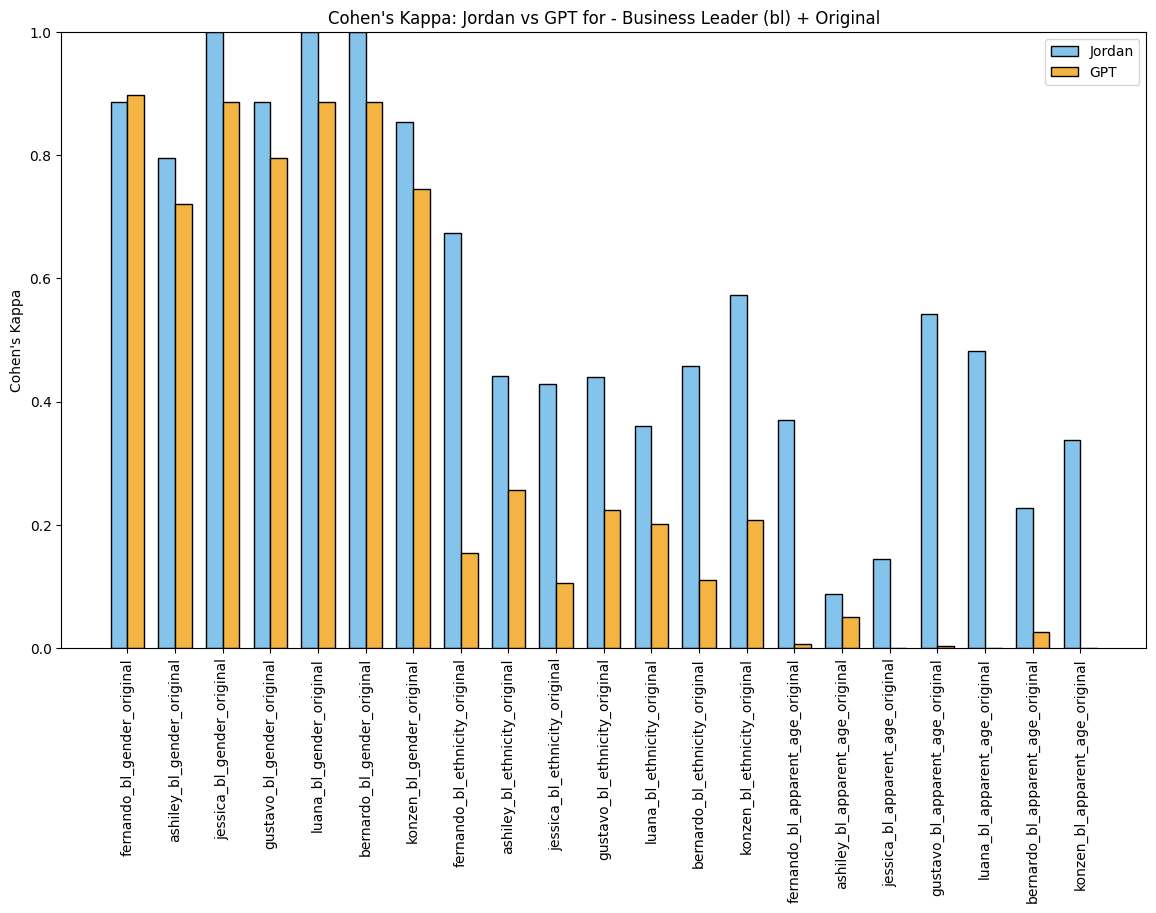

In [ ]:
plot_chart_comparison_kappa (jordan_kappa_results,gpt_kappa_results,'original','bl')

In [ ]:
columns_with_nans = data.columns[data.isna().any()]

print("Colunas com NaNs:")
print(columns_with_nans)

Colunas com NaNs:
Index([], dtype='object')


In [ ]:
data[['ID','gpt_nr_original_gender','luana_nr_gender_original']]
#print(cohen_kappa_score(data['gpt_nr_original_gender'], data['luana_nr_gender_original']))

print(len(data[data.jordan_ff_gender_original !='Female']))

200


In [ ]:
kappa_ff_gender = cohen_kappa_score(data['gpt_nr_original_gender'], data['fernando_nr_gender_original'])
kappa_ff_gender

0.0

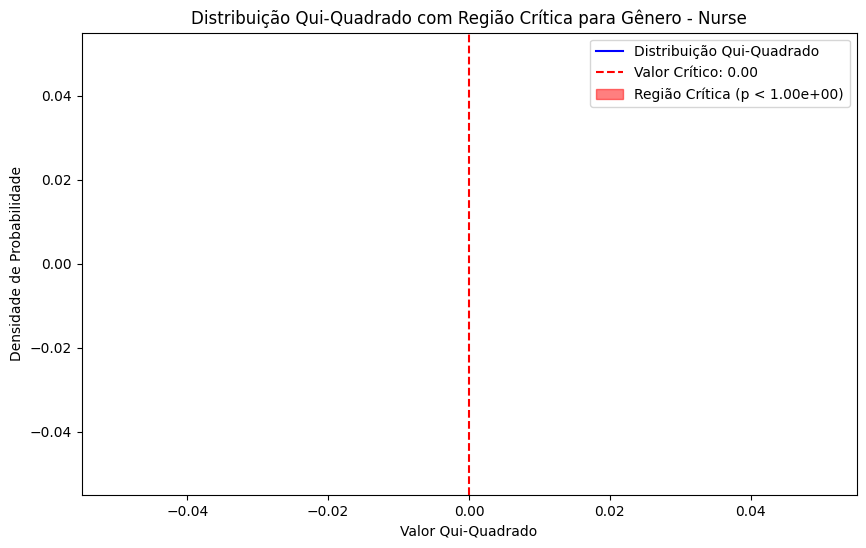

Chi2: 0.0, p-value: 1.0, dof: 0


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Abrir o arquivo Excel
file_path = 'full_data_original_vs_debiased.xlsx'
data = pd.read_excel(file_path)

# Criar uma tabela de contingência para gênero na profissão "Nurse"

contingency_table_gender_nurse = pd.crosstab(data['gpt_nr_original_gender'], data['gpt_nr_debiased_gender'])

# Aplicar o Chi-Squared Test na tabela de contingência
chi2, p, dof, expected = chi2_contingency(contingency_table_gender_nurse)

# Gerar valores para a distribuição qui-quadrado
x = np.linspace(0, chi2 + 10, 500)
y = stats.chi2.pdf(x, dof)

# Plotar a distribuição qui-quadrado
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Distribuição Qui-Quadrado', color='blue')

# Marcar o valor crítico do teste
plt.axvline(chi2, color='red', linestyle='--', label=f'Valor Crítico: {chi2:.2f}')

# Sombrear a área crítica (região de rejeição)
x_crit = np.linspace(chi2, chi2 + 10, 500)
y_crit = stats.chi2.pdf(x_crit, dof)
plt.fill_between(x_crit, y_crit, color='red', alpha=0.5, label=f'Região Crítica (p < {p:.2e})')

# Adicionar títulos e legendas
plt.title('Distribuição Qui-Quadrado com Região Crítica para Gênero - Nurse')
plt.xlabel('Valor Qui-Quadrado')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.show()

# Mostrar os resultados do teste
print(f'Chi2: {chi2}, p-value: {p}, dof: {dof}')


In [ ]:
print(contingency_table_gender_nurse)

gpt_nr_debiased_gender  Dunno  Female  Male
gpt_nr_original_gender                     
Female                      4     147    49


In [ ]:
import pandas as pd

def create_kappa_table(nurse_data_original, firefighter_data_original, leader_data_original, nurse_data_debiased, firefighter_data_debiased, leader_data_debiased):
    # Lista de avaliadores e características
    evaluators = ['fernando', 'jordan', 'ashiley', 'jessica', 'gustavo', 'luana', 'bernardo', 'konzen']
    professions = ['Nurse', 'Firefighter', 'Business Leader']
    characteristics = ['gender', 'ethnicity', 'apparent_age']

    # Agrupar os dados originais e debiased em um único dicionário para cada profissão
    original_data = {
        'Nurse': nurse_data_original,
        'Firefighter': firefighter_data_original,
        'Business Leader': leader_data_original
    }

    debiased_data = {
        'Nurse': nurse_data_debiased,
        'Firefighter': firefighter_data_debiased,
        'Business Leader': leader_data_debiased
    }

    # Criar um DataFrame vazio
    columns = ['Evaluator', 'Profession', 'Characteristic', 'Original', 'Debiased']
    df = pd.DataFrame(columns=columns)

    profession_suffix = {
        'Nurse': 'nr',
        'Firefighter': 'ff',
        'Business Leader': 'bl'
    }


    rows = []
    # Preencher o DataFrame com os valores originais e debiased
    for profession in professions:
        suffix = profession_suffix[profession]  # Pega o sufixo correto da profissão
        for evaluator in evaluators:
            for characteristic in characteristics:
                # Formatar as chaves para cada profissão e avaliador
                original_key = f'{evaluator}_{suffix}_{characteristic}_original'
                debiased_key = f'{evaluator}_{suffix}_{characteristic}_debiased'

                # Obter valores originais e debiased
                original_value = original_data[profession].get(original_key, 'N/A')
                debiased_value = debiased_data[profession].get(debiased_key, 'N/A')

                # Adicionar os dados à lista
                rows.append({
                    'Evaluator': evaluator,
                    'Profession': profession,
                    'Characteristic': characteristic,
                    'Original': original_value,
                    'Debiased': debiased_value
                })

    df = pd.DataFrame(rows)
    return df

# Exemplo de uso com os dados originais e debiased separados para cada profissão
nurse_data_original = {'fernando_nr_gender_original': 0.0,
 'jordan_nr_gender_original': 0.0,
 'ashiley_nr_gender_original': 0.0,
 'jessica_nr_gender_original': 0.0,
 'gustavo_nr_gender_original': 0.0,
 'luana_nr_gender_original': 0.0,
 'bernardo_nr_gender_original': 0.0,
 'konzen_nr_gender_original': 0.0,
 'fernando_nr_ethnicity_original': 0.5871097683786506,
 'jordan_nr_ethnicity_original': 0.5606416675181363,
 'ashiley_nr_ethnicity_original': 0.5665451679637474,
 'jessica_nr_ethnicity_original': 0.5562435500515996,
 'gustavo_nr_ethnicity_original': 0.5509822263797941,
 'luana_nr_ethnicity_original': 0.477283617197369,
 'bernardo_nr_ethnicity_original': 0.540877549955653,
 'konzen_nr_ethnicity_original': 0.545999657358232,
 'fernando_nr_apparent_age_original': 0.12137975919297106,
 'jordan_nr_apparent_age_original': 0.20842462364831438,
 'ashiley_nr_apparent_age_original': 0.020010748269212453,
 'jessica_nr_apparent_age_original': 0.18294395506191752,
 'gustavo_nr_apparent_age_original': -0.009087869669615056,
 'luana_nr_apparent_age_original': 0.07934465178438843,
 'bernardo_nr_apparent_age_original': 0.049096641809719066,
 'konzen_nr_apparent_age_original': 0.02678324168216173}

firefighter_data_original = {'fernando_ff_gender_original': 0.0,
 'jordan_ff_gender_original': 0.0,
 'ashiley_ff_gender_original': 0.0,
 'jessica_ff_gender_original': -0.004016064257028162,
 'gustavo_ff_gender_original': 0.0,
 'luana_ff_gender_original': -0.004016064257028162,
 'bernardo_ff_gender_original': -0.004016064257028162,
 'konzen_ff_gender_original': 0.0,
 'fernando_ff_ethnicity_original': 0.2589508742714405,
 'jordan_ff_ethnicity_original': 0.2530345471521942,
 'ashiley_ff_ethnicity_original': 0.2757371960682877,
 'jessica_ff_ethnicity_original': 0.2664139870399804,
 'gustavo_ff_ethnicity_original': 0.25596379535169134,
 'luana_ff_ethnicity_original': 0.20272402624366748,
 'bernardo_ff_ethnicity_original': 0.24305440026617864,
 'konzen_ff_ethnicity_original': 0.27684326363779277,
 'fernando_ff_apparent_age_original': 0.01615369274745737,
 'jordan_ff_apparent_age_original': 0.02512700810105728,
 'ashiley_ff_apparent_age_original': 0.005600327824067608,
 'jessica_ff_apparent_age_original': 0.0004915615271178231,
 'gustavo_ff_apparent_age_original': 0.004460885649004376,
 'luana_ff_apparent_age_original': 0.03692837553415396,
 'bernardo_ff_apparent_age_original': 0.03257722892007764,
 'konzen_ff_apparent_age_original': 0.000642045613153619}


leader_data_original = {'fernando_bl_gender_original': 0.8976982097186701,
 'jordan_bl_gender_original': 0.8866213151927438,
 'ashiley_bl_gender_original': 0.7204100652376514,
 'jessica_bl_gender_original': 0.8866213151927438,
 'gustavo_bl_gender_original': 0.7953964194373402,
 'luana_bl_gender_original': 0.8866213151927438,
 'bernardo_bl_gender_original': 0.8866213151927438,
 'konzen_bl_gender_original': 0.7457088366179275,
 'fernando_bl_ethnicity_original': 0.15437376679507664,
 'jordan_bl_ethnicity_original': 0.22827326142243265,
 'ashiley_bl_ethnicity_original': 0.2570692138579336,
 'jessica_bl_ethnicity_original': 0.10476190476190483,
 'gustavo_bl_ethnicity_original': 0.22376237623762374,
 'luana_bl_ethnicity_original': 0.20169053768490264,
 'bernardo_bl_ethnicity_original': 0.11093931194433715,
 'konzen_bl_ethnicity_original': 0.20755353228797846,
 'fernando_bl_apparent_age_original': 0.006711409395973145,
 'jordan_bl_apparent_age_original': 0.012572830420116587,
 'ashiley_bl_apparent_age_original': 0.04956566172713328,
 'jessica_bl_apparent_age_original': -0.004968062455642297,
 'gustavo_bl_apparent_age_original': 0.0036452004860266785,
 'luana_bl_apparent_age_original': -0.004431314623338345,
 'bernardo_bl_apparent_age_original': 0.02560455192034139,
 'konzen_bl_apparent_age_original': -0.0017889087656530744}


nurse_data_debiased = {'fernando_nr_gender_debiased': 0.7764040510324872,
 'jordan_nr_gender_debiased': 0.8553202683151387,
 'ashiley_nr_gender_debiased': 0.8290148625542549,
 'jessica_nr_gender_debiased': 0.8052201012855473,
 'gustavo_nr_gender_debiased': 0.8071625344352618,
 'luana_nr_gender_debiased': 0.7528728530829112,
 'bernardo_nr_gender_debiased': 0.8421675654346968,
 'konzen_nr_gender_debiased': 0.8039728175640356,
 'fernando_nr_ethnicity_debiased': 0.4450225459590704,
 'jordan_nr_ethnicity_debiased': 0.4384683039036601,
 'ashiley_nr_ethnicity_debiased': 0.4683469528404056,
 'jessica_nr_ethnicity_debiased': 0.40083455187417527,
 'gustavo_nr_ethnicity_debiased': 0.4620834426659669,
 'luana_nr_ethnicity_debiased': 0.3929805301733881,
 'bernardo_nr_ethnicity_debiased': 0.4036552425719999,
 'konzen_nr_ethnicity_debiased': 0.43145925457991163,
 'fernando_nr_apparent_age_debiased': 0.13367091696662803,
 'jordan_nr_apparent_age_debiased': 0.26929246123685613,
 'ashiley_nr_apparent_age_debiased': 0.08931698774080554,
 'jessica_nr_apparent_age_debiased': 0.14264597191426465,
 'gustavo_nr_apparent_age_debiased': 0.055942421834836775,
 'luana_nr_apparent_age_debiased': 0.11350934669493162,
 'bernardo_nr_apparent_age_debiased': 0.04450590897661533,
 'konzen_nr_apparent_age_debiased': 0.113915553467141}

firefighter_data_debiased={'fernando_ff_gender_debiased': 0.7232704402515724,
 'jordan_ff_gender_debiased': 0.6213017751479291,
 'ashiley_ff_gender_debiased': 0.6375,
 'jessica_ff_gender_debiased': 0.6107382550335572,
 'gustavo_ff_gender_debiased': 0.7197452229299364,
 'luana_ff_gender_debiased': 0.7142857142857143,
 'bernardo_ff_gender_debiased': 0.5512820512820513,
 'konzen_ff_gender_debiased': 0.5402298850574713,
 'fernando_ff_ethnicity_debiased': 0.22406799985892156,
 'jordan_ff_ethnicity_debiased': 0.23178992946434807,
 'ashiley_ff_ethnicity_debiased': 0.24946865037194477,
 'jessica_ff_ethnicity_debiased': 0.24997395742907746,
 'gustavo_ff_ethnicity_debiased': 0.2618676779305207,
 'luana_ff_ethnicity_debiased': 0.22744671138111472,
 'bernardo_ff_ethnicity_debiased': 0.2407199100112486,
 'konzen_ff_ethnicity_debiased': 0.2438183825743635,
 'fernando_ff_apparent_age_debiased': 0.029905178701677526,
 'jordan_ff_apparent_age_debiased': 0.040959040959041015,
 'ashiley_ff_apparent_age_debiased': 0.015869110591708813,
 'jessica_ff_apparent_age_debiased': 0.0033594624860021627,
 'gustavo_ff_apparent_age_debiased': 0.009508716323296418,
 'luana_ff_apparent_age_debiased': 0.0045184975995480325,
 'bernardo_ff_apparent_age_debiased': -0.0038910505836575737,
 'konzen_ff_apparent_age_debiased': -0.009795622203410348}

leader_data_debiased = {'fernando_bl_gender_debiased': 0.6954314720812182,
 'jordan_bl_gender_debiased': 0.6724890829694323,
 'ashiley_bl_gender_debiased': 0.7150259067357513,
 'jessica_bl_gender_debiased': 0.7883597883597884,
 'gustavo_bl_gender_debiased': 0.8009950248756219,
 'luana_bl_gender_debiased': 0.7687861271676302,
 'bernardo_bl_gender_debiased': 0.6825396825396826,
 'konzen_bl_gender_debiased': 0.7235023041474654,
 'fernando_bl_ethnicity_debiased': 0.3301079270561965,
 'jordan_bl_ethnicity_debiased': 0.334092202618099,
 'ashiley_bl_ethnicity_debiased': 0.35409321205297617,
 'jessica_bl_ethnicity_debiased': 0.24333808531637235,
 'gustavo_bl_ethnicity_debiased': 0.29160440533510434,
 'luana_bl_ethnicity_debiased': 0.32220766645782306,
 'bernardo_bl_ethnicity_debiased': 0.26317010907403104,
 'konzen_bl_ethnicity_debiased': 0.2926663648709823,
 'fernando_bl_apparent_age_debiased': 0.1106608127884724,
 'jordan_bl_apparent_age_debiased': 0.24528301886792447,
 'ashiley_bl_apparent_age_debiased': 0.016022870819759283,
 'jessica_bl_apparent_age_debiased': 0.07828655834564258,
 'gustavo_bl_apparent_age_debiased': 0.03695777430241176,
 'luana_bl_apparent_age_debiased': 0.0379080667708247,
 'bernardo_bl_apparent_age_debiased': 0.0068829891838742,
 'konzen_bl_apparent_age_debiased': 0.0876259266299183}



# Criar a tabela
table = create_kappa_table(nurse_data_original, firefighter_data_original, leader_data_original, nurse_data_debiased, firefighter_data_debiased, leader_data_debiased)

# Exibir a tabela no formato markdown
print(table.to_markdown(index=False))

# Se quiser salvar em um arquivo CSV
# table.to_csv('kappa_comparison_table.csv', index=False)

# Exemplo de uso com os dados de Nurse, Firefighter e Business Leader

| Evaluator   | Profession      | Characteristic   |     Original |    Debiased |
|:------------|:----------------|:-----------------|-------------:|------------:|
| fernando    | Nurse           | gender           |  0           |  0.776404   |
| fernando    | Nurse           | ethnicity        |  0.58711     |  0.445023   |
| fernando    | Nurse           | apparent_age     |  0.12138     |  0.133671   |
| jordan      | Nurse           | gender           |  0           |  0.85532    |
| jordan      | Nurse           | ethnicity        |  0.560642    |  0.438468   |
| jordan      | Nurse           | apparent_age     |  0.208425    |  0.269292   |
| ashiley     | Nurse           | gender           |  0           |  0.829015   |
| ashiley     | Nurse           | ethnicity        |  0.566545    |  0.468347   |
| ashiley     | Nurse           | apparent_age     |  0.0200107   |  0.089317   |
| jessica     | Nurse           | gender           |  0           |  0.80522    |
| jessica     | 

In [ ]:
import pandas as pd
import numpy as np

def create_kappa_summary(jordan_kappa_results,var):
    # List of professions and characteristics
    professions = ['Nurse', 'Firefighter', 'Business Leader']
    characteristics = ['gender', 'ethnicity', 'apparent_age']
    profession_suffix = {
        'Nurse': 'nr',
        'Firefighter': 'ff',
        'Business Leader': 'bl'
    }

    # Initialize the rows list to collect data for the DataFrame
    rows = []

    for prof in professions:
        suffix = profession_suffix[prof]

        # Initialize dictionaries to hold lists of kappa values for each characteristic for original and debiased
        kappa_values_original = {char: [] for char in characteristics}
        kappa_values_debiased = {char: [] for char in characteristics}

        # Filter jordan_kappa_results for the current profession
        filtered_results = [result for result in jordan_kappa_results if result[0] == suffix]

        # Extract data from filtered results, excluding Jordan
        for _, oridebias, data in filtered_results:
            for key, value in data.items():
                # Exclude Jordan's values
                if var not in key:
                    print(f'our key is {key}')
                    for characteristic in characteristics:
                        if characteristic in key and suffix in key:
                            # Append the value to the appropriate list (original or debiased)
                            if oridebias == 'original':
                                kappa_values_original[characteristic].append(value)
                            elif oridebias == 'debiased':
                                kappa_values_debiased[characteristic].append(value)

        # Calculate the median for each characteristic
        for characteristic in characteristics:
            median_value_original = np.nanmedian(kappa_values_original[characteristic])
            median_value_debiased = np.nanmedian(kappa_values_debiased[characteristic])

            # Add the results to rows
            rows.append({
                'Profession': prof,
                'Characteristic': characteristic,
                'Median Kappa (Original)': median_value_original,
                'Median Kappa (Debiased)': median_value_debiased
            })

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df

# Example usage:
# df_summary = create_kappa_summary_excluding_jordan(jordan_kappa_results)
# print(df_summary)


In [ ]:
jordan_df_summary = create_kappa_summary(jordan_kappa_results,'jordan')
jordan_df_summary

our key is fernando_nr_gender_original
our key is ashiley_nr_gender_original
our key is jessica_nr_gender_original
our key is gustavo_nr_gender_original
our key is luana_nr_gender_original
our key is bernardo_nr_gender_original
our key is konzen_nr_gender_original
our key is fernando_nr_ethnicity_original
our key is ashiley_nr_ethnicity_original
our key is jessica_nr_ethnicity_original
our key is gustavo_nr_ethnicity_original
our key is luana_nr_ethnicity_original
our key is bernardo_nr_ethnicity_original
our key is konzen_nr_ethnicity_original
our key is fernando_nr_apparent_age_original
our key is ashiley_nr_apparent_age_original
our key is jessica_nr_apparent_age_original
our key is gustavo_nr_apparent_age_original
our key is luana_nr_apparent_age_original
our key is bernardo_nr_apparent_age_original
our key is konzen_nr_apparent_age_original
our key is fernando_nr_gender_debiased
our key is ashiley_nr_gender_debiased
our key is jessica_nr_gender_debiased
our key is gustavo_nr_gende

,Profession,Characteristic,Median Kappa (Original),Median Kappa (Debiased)
0,Nurse,gender,0.000000,0.848150
1,Nurse,ethnicity,0.804360,0.671701
2,Nurse,apparent_age,0.329531,0.444894
3,Firefighter,gender,0.000000,0.730174
4,Firefighter,ethnicity,0.696832,0.767928
5,Firefighter,apparent_age,0.131039,0.216373
6,Business Leader,gender,0.886364,0.780171
7,Business Leader,ethnicity,0.441012,0.578547
8,Business Leader,apparent_age,0.338479,0.226020


In [ ]:
gpt_df_summary = create_kappa_summary(gpt_kappa_results,'xxxxxx')
gpt_df_summary

our key is fernando_nr_gender_original
our key is jordan_nr_gender_original
our key is ashiley_nr_gender_original
our key is jessica_nr_gender_original
our key is gustavo_nr_gender_original
our key is luana_nr_gender_original
our key is bernardo_nr_gender_original
our key is konzen_nr_gender_original
our key is fernando_nr_ethnicity_original
our key is jordan_nr_ethnicity_original
our key is ashiley_nr_ethnicity_original
our key is jessica_nr_ethnicity_original
our key is gustavo_nr_ethnicity_original
our key is luana_nr_ethnicity_original
our key is bernardo_nr_ethnicity_original
our key is konzen_nr_ethnicity_original
our key is fernando_nr_apparent_age_original
our key is jordan_nr_apparent_age_original
our key is ashiley_nr_apparent_age_original
our key is jessica_nr_apparent_age_original
our key is gustavo_nr_apparent_age_original
our key is luana_nr_apparent_age_original
our key is bernardo_nr_apparent_age_original
our key is konzen_nr_apparent_age_original
our key is fernando_nr

,Profession,Characteristic,Median Kappa (Original),Median Kappa (Debiased)
0,Nurse,gender,0.000000,0.806191
1,Nurse,ethnicity,0.553613,0.434964
2,Nurse,apparent_age,0.064221,0.113712
3,Firefighter,gender,0.000000,0.629401
4,Firefighter,ethnicity,0.257457,0.242269
5,Firefighter,apparent_age,0.010877,0.007014
6,Business Leader,gender,0.886621,0.719264
7,Business Leader,ethnicity,0.204622,0.307437
8,Business Leader,apparent_age,0.005178,0.058097


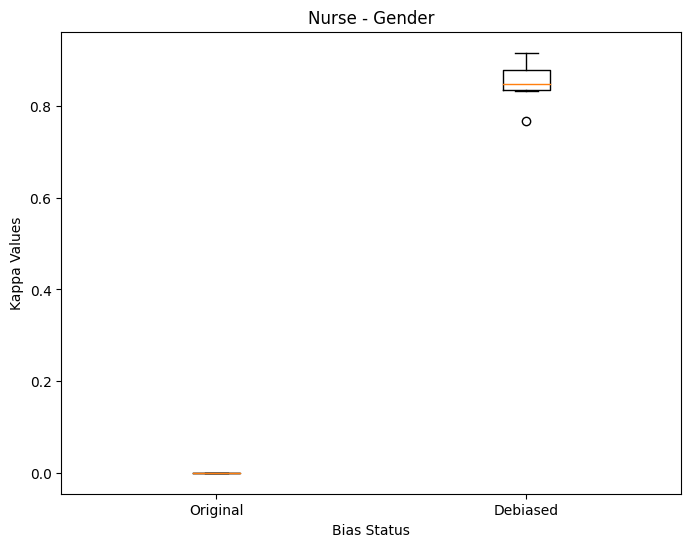

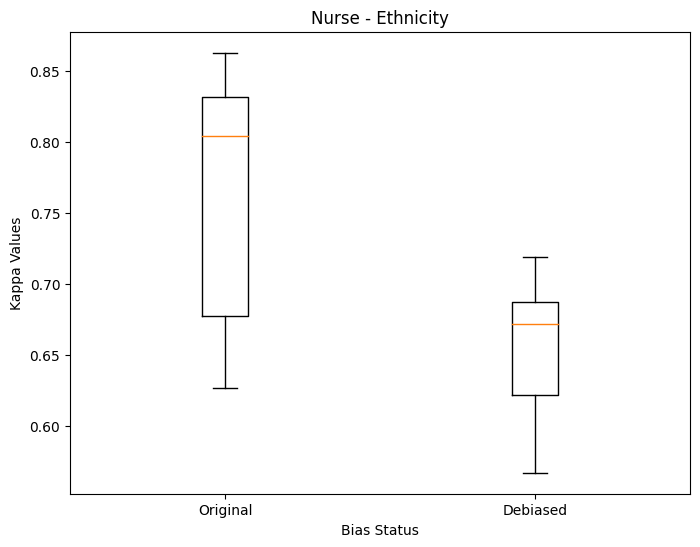

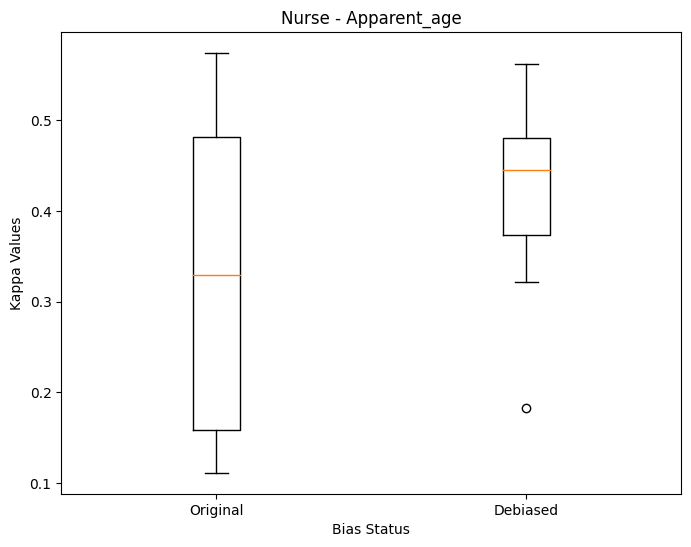

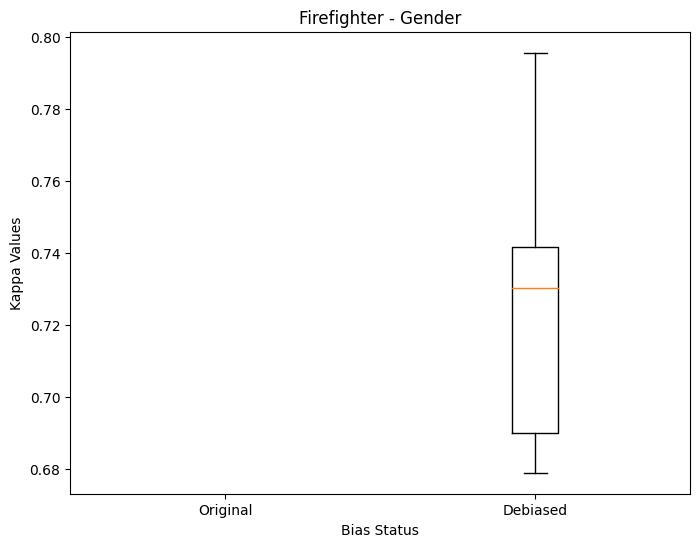

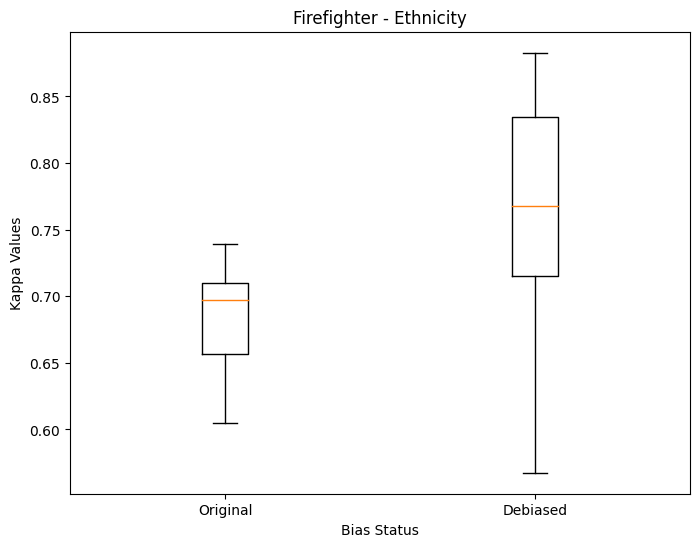

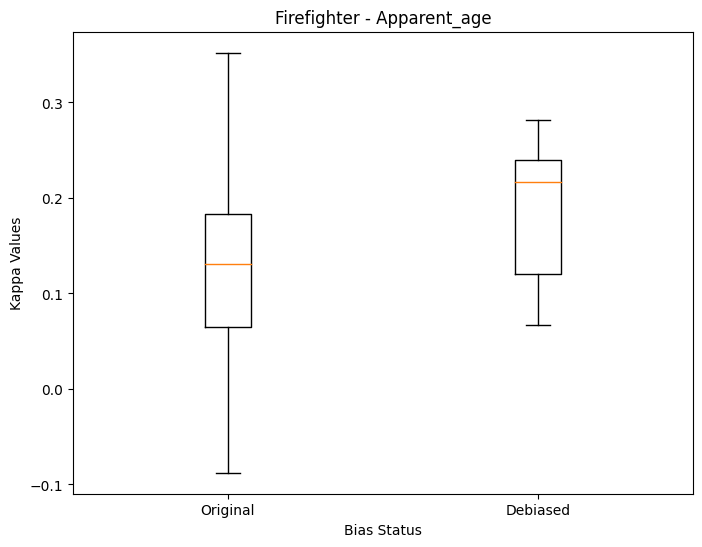

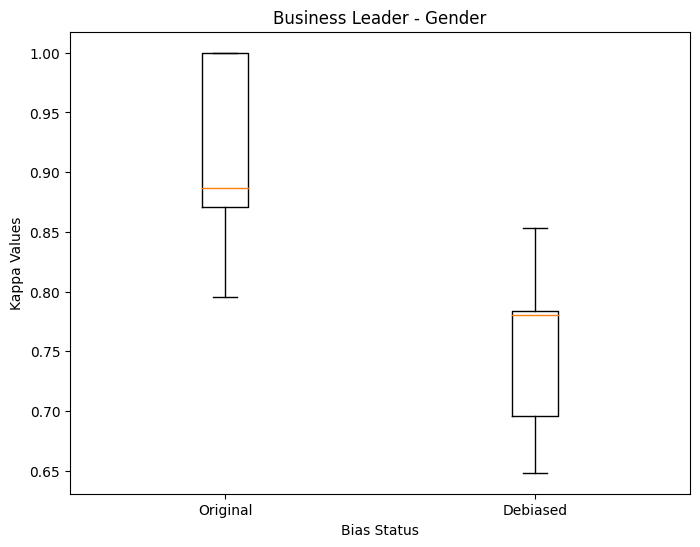

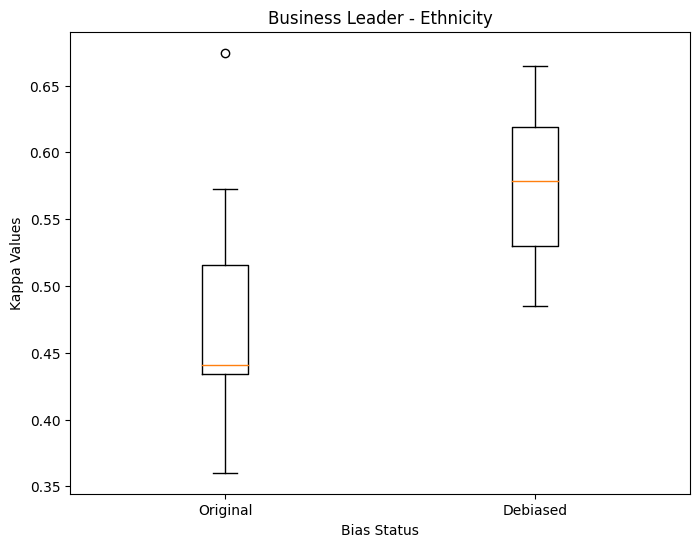

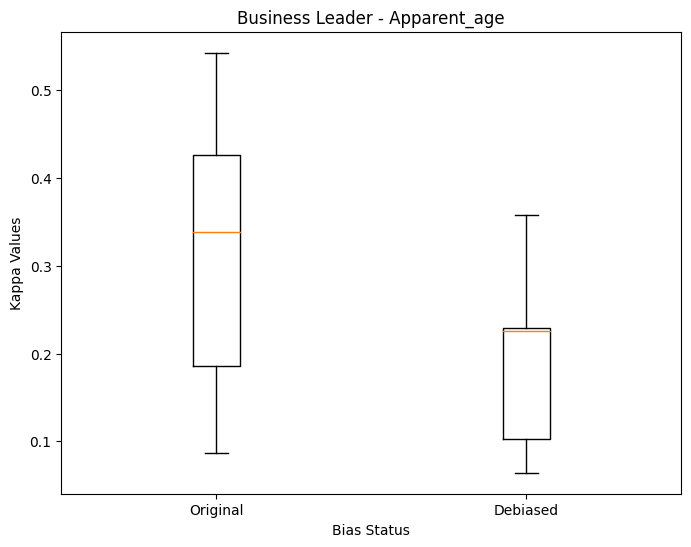

In [ ]:
import matplotlib.pyplot as plt

def create_kappa_boxplots_excluding_jordan(jordan_kappa_results):
    # List of professions and characteristics
    professions = ['Nurse', 'Firefighter', 'Business Leader']
    characteristics = ['gender', 'ethnicity', 'apparent_age']
    profession_suffix = {
        'Nurse': 'nr',
        'Firefighter': 'ff',
        'Business Leader': 'bl'
    }

    # Iterate over each profession and characteristic
    for prof in professions:
        suffix = profession_suffix[prof]

        # Initialize dictionaries to hold lists of kappa values for original and debiased
        kappa_values_original = {char: [] for char in characteristics}
        kappa_values_debiased = {char: [] for char in characteristics}

        # Filter jordan_kappa_results for the current profession
        filtered_results = [result for result in jordan_kappa_results if result[0] == suffix]

        # Extract data from filtered results, excluding Jordan
        for _, oridebias, data in filtered_results:
            for key, value in data.items():
                # Exclude keys that start with "jordan_"
                if not key.startswith('jordan_'):
                    for characteristic in characteristics:
                        if characteristic in key and suffix in key:
                            # Append the value to the appropriate list (original or debiased)
                            if oridebias == 'original':
                                kappa_values_original[characteristic].append(value)
                            elif oridebias == 'debiased':
                                kappa_values_debiased[characteristic].append(value)

        # Create boxplots for each characteristic in the current profession
        for characteristic in characteristics:
            # Data to plot
            data_to_plot = [
                kappa_values_original[characteristic],
                kappa_values_debiased[characteristic]
            ]

            # Create a figure for each characteristic
            plt.figure(figsize=(8, 6))
            plt.boxplot(data_to_plot, labels=['Original', 'Debiased'])
            plt.title(f'{prof} - {characteristic.capitalize()}')
            plt.ylabel('Kappa Values')
            plt.xlabel('Bias Status')
            plt.show()

# Example usage:
create_kappa_boxplots_excluding_jordan(jordan_kappa_results)


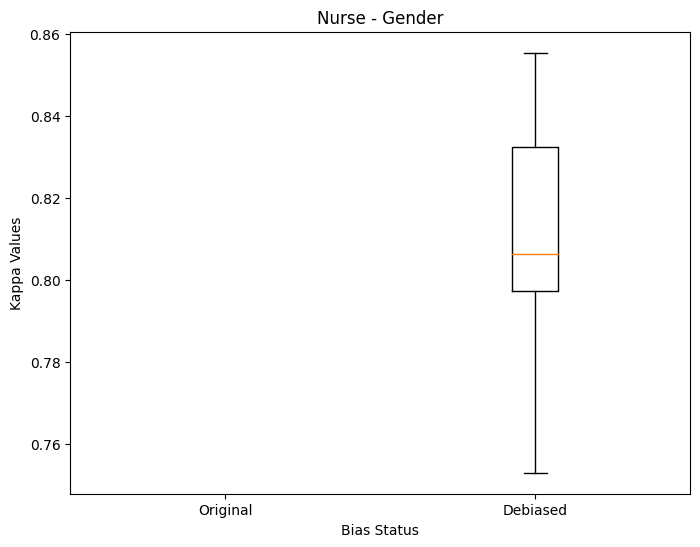

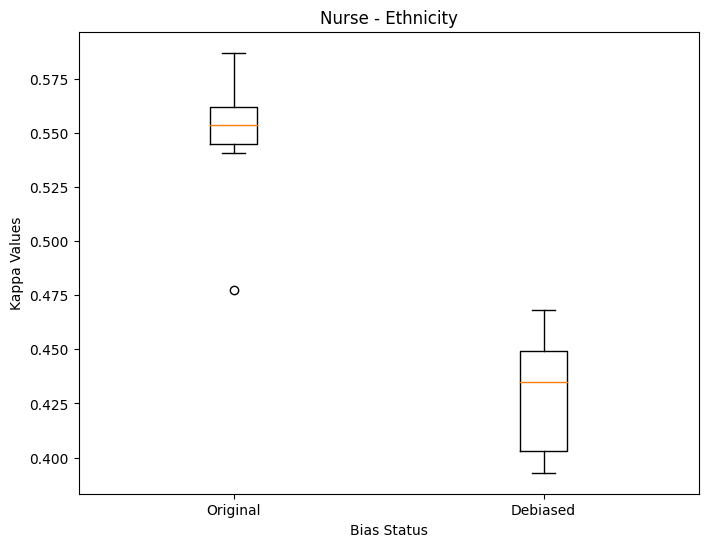

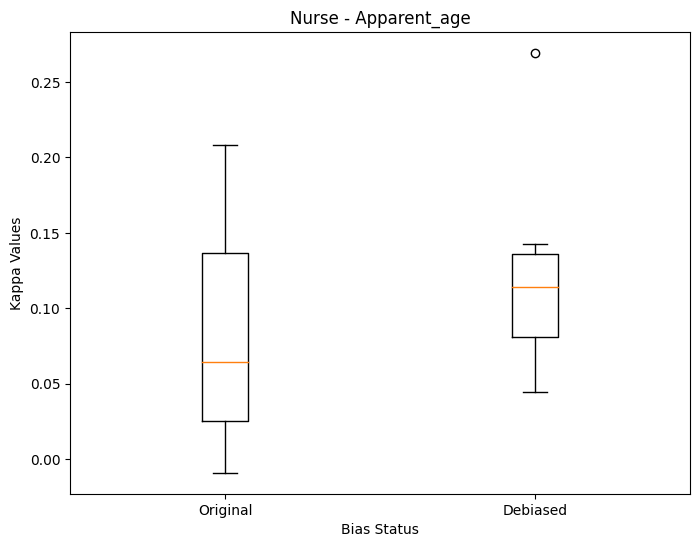

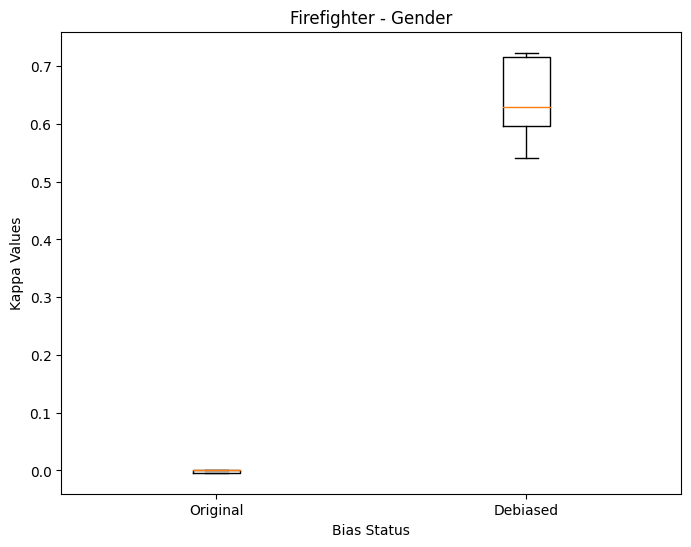

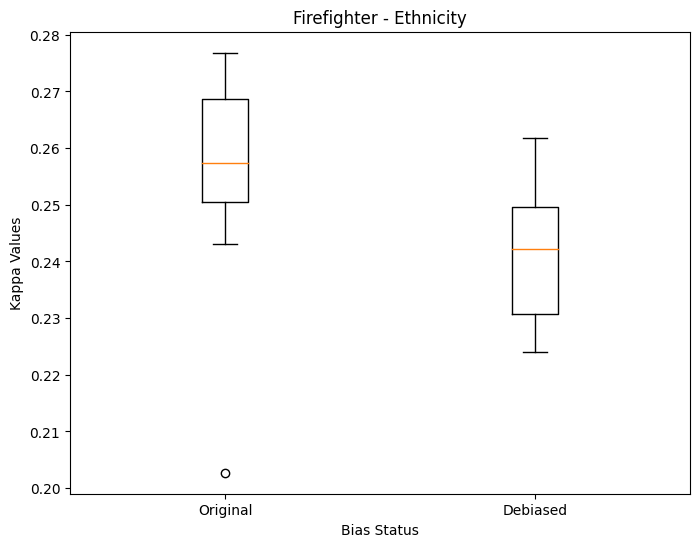

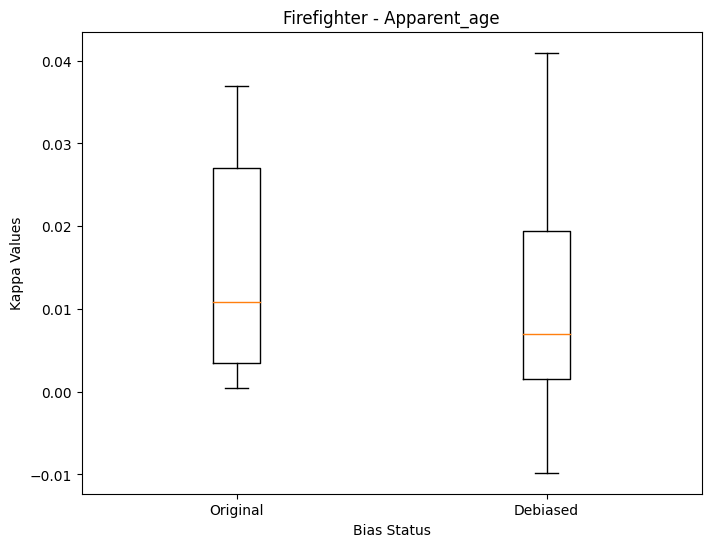

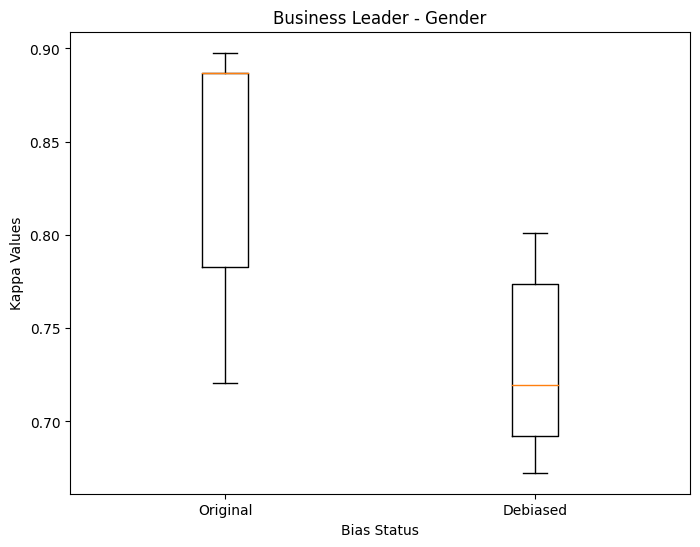

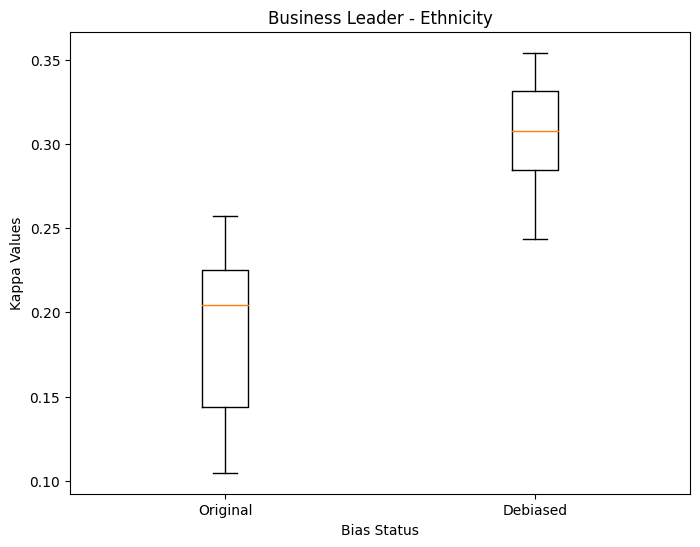

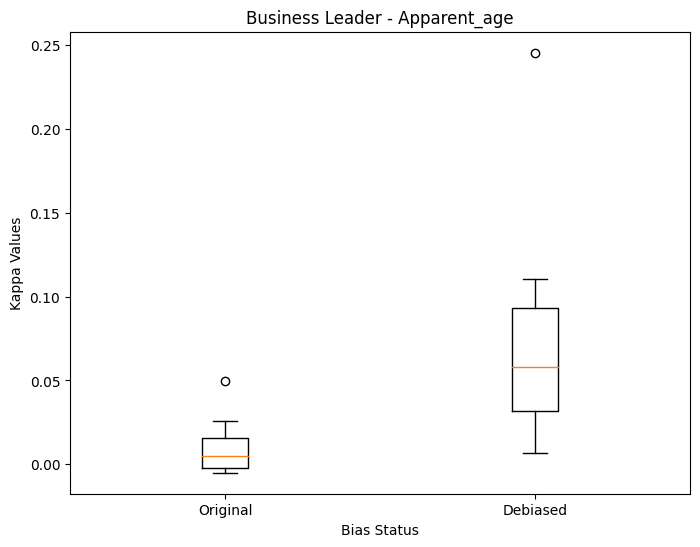

In [ ]:
import matplotlib.pyplot as plt

def create_kappa_boxplots(jordan_kappa_results):
    # List of professions and characteristics
    professions = ['Nurse', 'Firefighter', 'Business Leader']
    characteristics = ['gender', 'ethnicity', 'apparent_age']
    profession_suffix = {
        'Nurse': 'nr',
        'Firefighter': 'ff',
        'Business Leader': 'bl'
    }

    # Iterate over each profession and characteristic
    for prof in professions:
        suffix = profession_suffix[prof]

        # Initialize dictionaries to hold lists of kappa values for original and debiased
        kappa_values_original = {char: [] for char in characteristics}
        kappa_values_debiased = {char: [] for char in characteristics}

        # Filter jordan_kappa_results for the current profession
        filtered_results = [result for result in jordan_kappa_results if result[0] == suffix]

        # Extract data from filtered results
        for _, oridebias, data in filtered_results:
            for key, value in data.items():
                for characteristic in characteristics:
                    if characteristic in key and suffix in key:
                        # Append the value to the appropriate list (original or debiased)
                        if oridebias == 'original':
                            kappa_values_original[characteristic].append(value)
                        elif oridebias == 'debiased':
                            kappa_values_debiased[characteristic].append(value)

        # Create boxplots for each characteristic in the current profession
        for characteristic in characteristics:
            # Data to plot
            data_to_plot = [
                kappa_values_original[characteristic],
                kappa_values_debiased[characteristic]
            ]

            # Create a figure for each characteristic
            plt.figure(figsize=(8, 6))
            plt.boxplot(data_to_plot, labels=['Original', 'Debiased'])
            plt.title(f'{prof} - {characteristic.capitalize()}')
            plt.ylabel('Kappa Values')
            plt.xlabel('Bias Status')
            plt.show()

# Example usage:
create_kappa_boxplots(gpt_kappa_results)


In [40]:

from scipy.stats import chi2_contingency
def perform_chi_squared_tests_all_evaluators(df, professions, characteristics):
    results = []

    # Get all unique evaluators by extracting unique prefixes from column names
    evaluators = set(col.split('_')[0] for col in df.columns if '_' in col)

    for evaluator in evaluators:
        for prof in professions:
            for char in characteristics:
                # Define columns for original and debiased for each evaluator
                #if evaluator == 'gpt':
                #  original_col = f'{evaluator}_{prof}_original_{char}'
                #  debiased_col = f'{evaluator}_{prof}_debiased_{char}'
                #else:
                original_col = f'{evaluator}_{prof}_{char}_original'
                debiased_col = f'{evaluator}_{prof}_{char}_debiased'

                # Ensure both columns exist in the dataframe
                print(original_col)
                if original_col in df.columns and debiased_col in df.columns:
                    # Create a contingency table for the current evaluator, profession, and characteristic
                    contingency_table = pd.crosstab(df[original_col], df[debiased_col])

                    # Perform the chi-squared test
                    chi2, p, dof, expected = chi2_contingency(contingency_table)

                    # Store the result
                    results.append({
                        'Evaluator': evaluator,
                        'Profession': prof,
                        'Characteristic': char,
                        'Chi2': chi2,
                        'p-value': p,
                        'Degrees of Freedom': dof,
                        'Significant': 'Yes' if p < 0.05 else 'No'
                    })

    # Convert the results to a DataFrame for easier viewing
    df_results = pd.DataFrame(results)
    return df_results

# Perform chi-squared tests for all evaluators and display the results
professions = ['bl', 'ff', 'nr']
characteristics = ['gender', 'ethnicity', 'apparent_age']



file_path = 'full_data_original_vs_debiased.xlsx'
data = pd.read_excel(file_path)
columns_to_drop = [col for col in data.columns if 'mussi' in col or 'parraga' in col]


df_data = data.drop(columns=columns_to_drop)
df_filtered = df_data.drop(columns=[col for col in df_data.columns if col.startswith('gpt')])
df_data = df_filtered
def adjust_gpt_column_names(df):
    # Loop over all column names in the DataFrame
    new_columns = []
    for col in df.columns:
        # If the column starts with 'gpt', adjust the name
        if col.startswith('gpt'):
            parts = col.split('_')  # Split the column name by '_'
            if len(parts) > 3:  # Ensure there are at least 4 parts to swap
                # Swap the 3rd and 4th elements
                parts[2], parts[3] = parts[3], parts[2]
                # Rebuild the column name
                new_col_name = '_'.join(parts)
                new_columns.append(new_col_name)
            else:
                new_columns.append(col)
        else:
            new_columns.append(col)

    # Rename the columns in the DataFrame
    df.columns = new_columns
    return df

# Apply the function to the DataFrame
df_data_adjusted = adjust_gpt_column_names(df_data)

# Display the adjusted column names
df_data_adjusted.columns.tolist()


df_chi_squared_results_all = perform_chi_squared_tests_all_evaluators(df_data_adjusted, professions, characteristics)


bernardo_bl_gender_original
bernardo_bl_ethnicity_original
bernardo_bl_apparent_age_original
bernardo_ff_gender_original
bernardo_ff_ethnicity_original
bernardo_ff_apparent_age_original
bernardo_nr_gender_original
bernardo_nr_ethnicity_original
bernardo_nr_apparent_age_original
jessica_bl_gender_original
jessica_bl_ethnicity_original
jessica_bl_apparent_age_original
jessica_ff_gender_original
jessica_ff_ethnicity_original
jessica_ff_apparent_age_original
jessica_nr_gender_original
jessica_nr_ethnicity_original
jessica_nr_apparent_age_original
konzen_bl_gender_original
konzen_bl_ethnicity_original
konzen_bl_apparent_age_original
konzen_ff_gender_original
konzen_ff_ethnicity_original
konzen_ff_apparent_age_original
konzen_nr_gender_original
konzen_nr_ethnicity_original
konzen_nr_apparent_age_original
gustavo_bl_gender_original
gustavo_bl_ethnicity_original
gustavo_bl_apparent_age_original
gustavo_ff_gender_original
gustavo_ff_ethnicity_original
gustavo_ff_apparent_age_original
gustavo_nr

In [ ]:
df_chi_squared_results_all.to_csv('df_chi_squared_results_all.csv', index=False)

In [41]:
def perform_aggregated_chi_squared_tests(df, professions, characteristics):
    results = []

    for prof in professions:
        for char in characteristics:
            # Initialize a dictionary to collect counts for original and debiased across all evaluators
            aggregated_counts = {'Original': {}, 'Debiased': {}}

            # Loop through all evaluators and collect counts
            evaluators = set(col.split('_')[0] for col in df.columns if '_' in col)
            for evaluator in evaluators:
                if evaluator == 'gpt':
                    original_col = f'{evaluator}_{prof}_original_{char}'
                    debiased_col = f'{evaluator}_{prof}_debiased_{char}'
                else:
                    original_col = f'{evaluator}_{prof}_{char}_original'
                    debiased_col = f'{evaluator}_{prof}_{char}_debiased'

                # Aggregate counts if columns exist
                if original_col in df.columns and debiased_col in df.columns:
                    # Update aggregated counts
                    original_value_counts = df[original_col].value_counts()
                    debiased_value_counts = df[debiased_col].value_counts()

                    # Add counts to aggregated_counts dictionary
                    for category, count in original_value_counts.items():
                        aggregated_counts['Original'][category] = aggregated_counts['Original'].get(category, 0) + count
                    for category, count in debiased_value_counts.items():
                        aggregated_counts['Debiased'][category] = aggregated_counts['Debiased'].get(category, 0) + count

            # Convert aggregated counts into a DataFrame with aligned indices
            original_counts_series = pd.Series(aggregated_counts['Original'])
            debiased_counts_series = pd.Series(aggregated_counts['Debiased'])

            # Ensure both series have the same index
            combined_index = original_counts_series.index.union(debiased_counts_series.index)
            original_counts_series = original_counts_series.reindex(combined_index, fill_value=0)
            debiased_counts_series = debiased_counts_series.reindex(combined_index, fill_value=0)

            # Create a contingency table using these aligned counts
            contingency_table = pd.DataFrame({
                'Original': original_counts_series,
                'Debiased': debiased_counts_series
            })

            # Ensure the contingency table is valid for chi-squared test
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                # Perform the chi-squared test
                chi2, p, dof, expected = chi2_contingency(contingency_table)

                # Store the result
                results.append({
                    'Profession': prof,
                    'Characteristic': char,
                    'Chi2': chi2,
                    'p-value': p,
                    'Degrees of Freedom': dof,
                    'Significant': 'Yes' if p < 0.05 else 'No'
                })

    # Convert the results to a DataFrame for easier viewing
    df_results = pd.DataFrame(results)
    return df_results

# Perform chi-squared tests for aggregated data
df_chi_squared_aggregated_results = perform_aggregated_chi_squared_tests(df_data, professions, characteristics)
df_chi_squared_aggregated_results.head(10)  # Display the first few results


,Profession,Characteristic,Chi2,p-value,Degrees of Freedom,Significant
0,bl,gender,110.363688,8.156557e-26,1,Yes
1,bl,ethnicity,1687.124310,0.000000e+00,3,Yes
2,bl,apparent_age,2248.224423,0.000000e+00,2,Yes
3,ff,gender,451.713579,3.056292e-100,1,Yes
4,ff,ethnicity,8.915519,3.043546e-02,3,Yes
5,ff,apparent_age,121.087252,5.084373e-27,2,Yes
6,nr,gender,356.766961,1.424222e-79,1,Yes
7,nr,ethnicity,131.963576,2.041245e-28,3,Yes
8,nr,apparent_age,128.630953,1.169886e-28,2,Yes


In [42]:
def calculate_accuracy(df, professions, characteristics,type_original_or_debiased, reference='jordan'):
    results = []
    if type_original_or_debiased == 'debiased':
      type_original_or_debiased = '_debiased'
    else:
      type_original_or_debiased = '_original'
    print(f'our type is {type_original_or_debiased}')
    for prof in professions:
        for char in characteristics:
            reference_col = f'{reference}_{prof}_{char}{type_original_or_debiased}'

            evaluators = set(col.split('_')[0] for col in df.columns if col.startswith(reference) == False)
            for evaluator in evaluators:
                eval_col = f'{evaluator}_{prof}_{char}{type_original_or_debiased}'

                if reference_col in df.columns and eval_col in df.columns:
                    correct_predictions = (df[reference_col] == df[eval_col]).sum()
                    total_predictions = df[eval_col].notnull().sum()
                    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

                    # Store the result
                    results.append({
                        'Evaluator': evaluator,
                        'Profession': prof,
                        'Characteristic': char,
                        'Accuracy': accuracy
                    })

    df_results = pd.DataFrame(results)

    df_medians = df_results.groupby(['Profession', 'Characteristic']).agg({'Accuracy': 'median'}).reset_index()
    df_medians.rename(columns={'Accuracy': 'Median Accuracy'}, inplace=True)
    return df_results, df_medians

professions = ['bl', 'ff', 'nr']
characteristics = ['gender', 'ethnicity', 'apparent_age']

df_accuracy_results_original, df_median_accuracy_original = calculate_accuracy(df_data, professions, characteristics,'original')
df_accuracy_results_debiased, df_median_accuracy_debiased = calculate_accuracy(df_data, professions, characteristics,'debiased')

our type is _original
our type is _debiased


In [43]:
df_median_accuracy_original

,Profession,Characteristic,Median Accuracy
0,bl,apparent_age,0.880
1,bl,ethnicity,0.945
2,bl,gender,0.995
3,ff,apparent_age,0.750
4,ff,ethnicity,0.915
5,ff,gender,1.000
6,nr,apparent_age,0.615
7,nr,ethnicity,0.925
8,nr,gender,0.980


In [44]:
df_median_accuracy_debiased

,Profession,Characteristic,Median Accuracy
0,bl,apparent_age,0.555
1,bl,ethnicity,0.690
2,bl,gender,0.945
3,ff,apparent_age,0.575
4,ff,ethnicity,0.925
5,ff,gender,0.885
6,nr,apparent_age,0.760
7,nr,ethnicity,0.800
8,nr,gender,0.945


In [45]:
from statsmodels.stats.inter_rater import fleiss_kappa
import numpy as np
import pandas as pd

def map_categorical_to_numeric(df):
    mapping = {'Male': 0, 'Female': 1, 'Dunno': 2, 'Caucasian': 3, 'Asian': 4, 'Latino':5, 'African-American':6, 'Young':7,'Middle-Age':8,'Elderly':9}
    df_mapped = df.replace(mapping)
    return df_mapped

def calculate_fleiss_kappa_corrected(df, professions, characteristics, data_type='_original'):
    results = []

    for prof in professions:
        for char in characteristics:
            eval_data = []
            for idx, row in df.iterrows():
                ratings = []
                for evaluator in set(col.split('_')[0] for col in df.columns if 'gpt' not in col):
                    eval_col = f'{evaluator}_{prof}_{char}{data_type}'  # Adjust based on _original or _debiased
                    if eval_col in df.columns and not pd.isna(row[eval_col]):
                        ratings.append(row[eval_col])

                if len(ratings) > 1:
                    eval_data.append(ratings)

            if len(eval_data) > 0:
                ratings_df = pd.DataFrame(eval_data)

                ratings_df = map_categorical_to_numeric(ratings_df)

                count_table = ratings_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)

                if count_table.shape[1] > 1:
                    kappa_score = fleiss_kappa(count_table.to_numpy())
                else:
                    kappa_score = np.nan

                # Store the result
                results.append({
                    'Profession': prof,
                    'Characteristic': char,
                    'Data Type': data_type,
                    'Fleiss Kappa': kappa_score
                })
    df_kappa_results = pd.DataFrame(results)
    return df_kappa_results

df_fleiss_kappa_results_original = calculate_fleiss_kappa_corrected(df_data, professions, characteristics, '_original')
df_fleiss_kappa_results_debiased = calculate_fleiss_kappa_corrected(df_data, professions, characteristics, '_debiased')


<ipython-input-45-08de49cf0e33>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)
<ipython-input-45-08de49cf0e33>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)
<ipython-input-45-08de49cf0e33>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

In [46]:
df_fleiss_kappa_results_original

,Profession,Characteristic,Data Type,Fleiss Kappa
0,bl,gender,_original,0.853948
1,bl,ethnicity,_original,0.379560
2,bl,apparent_age,_original,0.153863
3,ff,gender,_original,-0.001879
4,ff,ethnicity,_original,0.642484
5,ff,apparent_age,_original,0.067898
6,nr,gender,_original,-0.004263
7,nr,ethnicity,_original,0.704906
8,nr,apparent_age,_original,0.248955


In [47]:
df_fleiss_kappa_results_debiased

,Profession,Characteristic,Data Type,Fleiss Kappa
0,bl,gender,_debiased,0.794985
1,bl,ethnicity,_debiased,0.513190
2,bl,apparent_age,_debiased,0.161380
3,ff,gender,_debiased,0.721827
4,ff,ethnicity,_debiased,0.682894
5,ff,apparent_age,_debiased,0.148431
6,nr,gender,_debiased,0.821181
7,nr,ethnicity,_debiased,0.631164
8,nr,apparent_age,_debiased,0.384005


In [ ]:
#0.01 - 0.20: Concordância leve.
#0.21 - 0.40: Concordância razoável.
#0.41 - 0.60: Concordância moderada.
#0.61 - 0.80: Concordância substancial.
#0.81 - 1.00: Concordância quase perfeita.

In [ ]:
df_filtered = df_data.filter(like='nr').filter(like='original').filter(like='gender')

In [ ]:
df_filtered.head()

,gpt_nr_gender_original,fernando_nr_gender_original,jordan_nr_gender_original,ashiley_nr_gender_original,jessica_nr_gender_original,gustavo_nr_gender_original,luana_nr_gender_original,bernardo_nr_gender_original,konzen_nr_gender_original
0,Female,Female,Female,Female,Female,Female,Female,Female,Female
1,Female,Female,Female,Female,Female,Female,Female,Female,Female
2,Female,Female,Female,Female,Female,Female,Female,Female,Female
3,Female,Female,Female,Female,Male,Female,Female,Female,Female
4,Female,Female,Female,Female,Female,Female,Female,Female,Female


In [ ]:
value_counts_per_column = df_filtered.apply(pd.Series.value_counts)

# Display the value counts for each column
print(value_counts_per_column)

        gpt_nr_gender_original  fernando_nr_gender_original  \
Female                   200.0                          196   
Male                       NaN                            4   

        jordan_nr_gender_original  ashiley_nr_gender_original  \
Female                      200.0                         195   
Male                          NaN                           5   

        jessica_nr_gender_original  gustavo_nr_gender_original  \
Female                         199                         194   
Male                             1                           6   

        luana_nr_gender_original  bernardo_nr_gender_original  \
Female                       197                          196   
Male                           3                            4   

        konzen_nr_gender_original  
Female                        198  
Male                            2  


In [ ]:

value_counts_per_row = df_filtered.apply(lambda row: row.value_counts(), axis=1)
filtered_value_counts = value_counts_per_row[value_counts_per_row.notna().sum(axis=1) > 1]

# Display the filtered result
print(filtered_value_counts.shape[0])

24


In [ ]:
df_filtered_2 = df_data.filter(like='jordan').filter(like='original').filter(like='gender').filter(like='bl')
df_filtered_2.value_counts()

,count
jordan_bl_gender_original,
Male,196
Female,4


In [ ]:
# Variations for 'original' and 'gender'
original_variations = ['original', 'debiased']
gender_variations = ['gender', 'ethnicity', 'apparent_age']

# Loop through each combination of 'original' and 'gender' variations
for original in original_variations:
    for gender in gender_variations:
        # Filter the dataframe based on current variations
        df_filtered = df_data.filter(like='jordan').filter(like=original).filter(like=gender).filter(like='ff')

        # Get value counts and calculate percentages
        value_counts = df_filtered.value_counts()
        total = value_counts.sum()  # Total number of counts
        percentages = (value_counts / total) * 100  # Calculate percentages

        # Combine value counts and percentages into a new dataframe
        df_results = pd.DataFrame({'Counts': value_counts, 'Percentage (%)': percentages})

        # Print the results
        print(f"Value counts and percentages for original: {original}, category: {gender}")
        print(df_results)
        print("\n")  # For better readability


Value counts and percentages for original: original, category: gender
                           Counts  Percentage (%)
jordan_ff_gender_original                        
Male                          200           100.0


Value counts and percentages for original: original, category: ethnicity
                              Counts  Percentage (%)
jordan_ff_ethnicity_original                        
Caucasian                        167            83.5
African-American                  21            10.5
Latino                            11             5.5
Asian                              1             0.5


Value counts and percentages for original: original, category: apparent_age
                                 Counts  Percentage (%)
jordan_ff_apparent_age_original                        
Middle-Age                          148            74.0
Young                                52            26.0


Value counts and percentages for original: debiased, category: gender
             

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
import numpy as np
import pandas as pd

def calculate_fleiss_kappa_with_override(df, professions, characteristics, data_type='_original'):
    results = []
    for prof in professions:
        for char in characteristics:
            eval_data = []
            for idx, row in df.iterrows():
                ratings = []
                for evaluator in set(col.split('_')[0] for col in df.columns):
                    eval_col = f'{evaluator}_{prof}_{char}{data_type}'
                    if eval_col in df.columns and not pd.isna(row[eval_col]):
                        ratings.append(row[eval_col])

                if len(ratings) > 1:
                    eval_data.append(ratings)

            if len(eval_data) > 0:
                ratings_df = pd.DataFrame(eval_data)
                ratings_df = map_categorical_to_numeric(ratings_df)

                count_table = ratings_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)

                # Check if all evaluators give the same rating for each item
                if count_table.nunique(axis=1).eq(1).all():
                    kappa_score = 1.0  # Manually set Fleiss' Kappa to 1 if there's total agreement
                else:
                    if count_table.shape[1] > 1:
                        kappa_score = fleiss_kappa(count_table.to_numpy())
                    else:
                        kappa_score = np.nan

                results.append({
                    'Profession': prof,
                    'Characteristic': char,
                    'Data Type': data_type,
                    'Fleiss Kappa': kappa_score
                })

    df_kappa_results = pd.DataFrame(results)
    return df_kappa_results

# Função para mapear categorias para valores numéricos
def map_categorical_to_numeric(df):
    mapping = {'Male': 0, 'Female': 1, 'Dunno': 2, 'Caucasian': 3, 'Asian': 4, 'Latino':5, 'African-American':6, 'Young':7,'Middle-Age':8,'Elderly':9}
    df_mapped = df.replace(mapping)
    return df_mapped

df_fleiss_kappa_results_original = calculate_fleiss_kappa_with_override(df_data, professions, characteristics, '_original')
df_fleiss_kappa_results_debiased = calculate_fleiss_kappa_with_override(df_data, professions, characteristics, '_debiased')



<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)
<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)
<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

In [38]:
# Filtering for 'bl_ethnicity_original' and performing value counts

df_filtered_bl_ethnicity_original = df_data.filter(like="bl").filter(like="ethnicity").filter(like="_original")

# Performing value counts on the filtered columns
value_counts_bl_ethnicity_original = df_filtered_bl_ethnicity_original.apply(pd.Series.value_counts)

value_counts_bl_ethnicity_original


,gpt_bl_ethnicity_original,fernando_bl_ethnicity_original,jordan_bl_ethnicity_original,ashiley_bl_ethnicity_original,jessica_bl_ethnicity_original,gustavo_bl_ethnicity_original,luana_bl_ethnicity_original,bernardo_bl_ethnicity_original,konzen_bl_ethnicity_original
African-American,3.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0
Asian,3.0,5.0,5.0,17.0,2.0,3.0,2.0,1.0,4.0
Caucasian,152.0,193.0,188.0,176.0,194.0,180.0,179.0,195.0,185.0
Dunno,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latino,NaN,NaN,5.0,5.0,2.0,15.0,16.0,1.0,9.0


In [ ]:
df_fleiss_kappa_results_original

,Profession,Characteristic,Data Type,Fleiss Kappa
0,bl,gender,_original,0.849870
1,bl,ethnicity,_original,0.302031
2,bl,apparent_age,_original,0.153863
3,ff,gender,_original,-0.002945
4,ff,ethnicity,_original,0.494271
5,ff,apparent_age,_original,0.067898
6,nr,gender,_original,-0.003944
7,nr,ethnicity,_original,0.664222
8,nr,apparent_age,_original,0.248955


In [ ]:
df_fleiss_kappa_results_debiased

,Profession,Characteristic,Data Type,Fleiss Kappa
0,bl,gender,_debiased,0.780801
1,bl,ethnicity,_debiased,0.456434
2,bl,apparent_age,_debiased,0.161380
3,ff,gender,_debiased,0.702488
4,ff,ethnicity,_debiased,0.515110
5,ff,apparent_age,_debiased,0.148431
6,nr,gender,_debiased,0.818262
7,nr,ethnicity,_debiased,0.577092
8,nr,apparent_age,_debiased,0.384005


In [ ]:
def calculate_fleiss_kappa_with_debug(df, professions, characteristics, data_type='_original'):
    results = []
    for prof in professions:
        for char in characteristics:
            eval_data = []
            for idx, row in df.iterrows():
                ratings = []
                for evaluator in set(col.split('_')[0] for col in df.columns):
                    eval_col = f'{evaluator}_{prof}_{char}{data_type}'
                    if eval_col in df.columns and not pd.isna(row[eval_col]):
                        ratings.append(row[eval_col])

                if len(ratings) > 1:
                    eval_data.append(ratings)

            if len(eval_data) > 0:
                ratings_df = pd.DataFrame(eval_data)
                ratings_df = map_categorical_to_numeric(ratings_df)

                # Debugging: Print out the ratings to see what's going on
                print(f"\nRatings for {prof} - {char} ({data_type}):")
                print(ratings_df.head())

                count_table = ratings_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)

                # Debugging: Print out the count table for more insight
                print(f"\nCount table for {prof} - {char} ({data_type}):")
                print(count_table.head())

                # Check if all evaluators give the same rating for each item
                if count_table.nunique(axis=1).eq(1).all():
                    kappa_score = 1.0  # Manually set Fleiss' Kappa to 1 if there's total agreement
                else:
                    if count_table.shape[1] > 1:
                        kappa_score = fleiss_kappa(count_table.to_numpy())
                    else:
                        kappa_score = np.nan

                # Debugging: Print out the kappa score for each case
                print(f"Fleiss Kappa for {prof} - {char} ({data_type}): {kappa_score}\n")

                results.append({
                    'Profession': prof,
                    'Characteristic': char,
                    'Data Type': data_type,
                    'Fleiss Kappa': kappa_score
                })

    df_kappa_results = pd.DataFrame(results)
    return df_kappa_results


In [ ]:
# Example usage with debug prints:
df_fleiss_kappa_results_original = calculate_fleiss_kappa_with_debug(df_data, professions, characteristics, '_original')
df_fleiss_kappa_results_debiased = calculate_fleiss_kappa_with_debug(df_data, professions, characteristics, '_debiased')

# Display the results
print(df_fleiss_kappa_results_original)
print(df_fleiss_kappa_results_debiased)


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Ratings for bl - gender (_original):
   0  1  2  3  4  5  6  7  8
0  0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  2  0  1  0  0
4  0  0  0  0  0  0  0  0  0

Count table for bl - gender (_original):
     0    1    2
0  9.0  0.0  0.0
1  9.0  0.0  0.0
2  9.0  0.0  0.0
3  7.0  1.0  1.0
4  9.0  0.0  0.0
Fleiss Kappa for bl - gender (_original): 0.8498701003705357


Ratings for bl - ethnicity (_original):
   0  1  2  3  4  5  6  7  8
0  3  3  3  3  3  3  3  3  3
1  3  3  3  3  3  3  3  3  3
2  3  3  3  5  2  3  3  3  3
3  3  3  3  3  2  3  3  3  3
4  3  3  3  3  3  3  3  3  3


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for bl - ethnicity (_original):
     2    3    4    5    6
0  0.0  9.0  0.0  0.0  0.0
1  0.0  9.0  0.0  0.0  0.0
2  1.0  7.0  0.0  1.0  0.0
3  1.0  8.0  0.0  0.0  0.0
4  0.0  9.0  0.0  0.0  0.0
Fleiss Kappa for bl - ethnicity (_original): 0.30203069314673614


Ratings for bl - apparent_age (_original):
   0  1  2  3  4  5  6  7
0  9  9  9  9  8  9  9  9
1  9  9  9  9  8  9  9  9
2  9  9  9  9  9  9  9  9
3  8  8  7  7  8  8  7  7
4  9  9  9  9  9  9  9  9


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for bl - apparent_age (_original):
     7    8    9
0  0.0  1.0  7.0
1  0.0  1.0  7.0
2  0.0  0.0  8.0
3  4.0  4.0  0.0
4  0.0  0.0  8.0
Fleiss Kappa for bl - apparent_age (_original): 0.15386306529134472


Ratings for ff - gender (_original):
   0  1  2  3  4  5  6  7  8
0  0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - gender (_original):
     0    1    2
0  9.0  0.0  0.0
1  9.0  0.0  0.0
2  9.0  0.0  0.0
3  9.0  0.0  0.0
4  9.0  0.0  0.0
Fleiss Kappa for ff - gender (_original): -0.0029451564116614267


Ratings for ff - ethnicity (_original):
   0  1  2  3  4  5  6  7  8
0  3  3  3  3  2  3  3  3  3
1  3  3  3  3  3  3  3  3  3
2  3  3  3  3  3  3  3  3  3
3  3  3  3  3  3  3  3  3  3
4  3  3  3  3  2  5  3  3  3


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - ethnicity (_original):
     2    3    4    5    6
0  1.0  8.0  0.0  0.0  0.0
1  0.0  9.0  0.0  0.0  0.0
2  0.0  9.0  0.0  0.0  0.0
3  0.0  9.0  0.0  0.0  0.0
4  1.0  7.0  0.0  1.0  0.0
Fleiss Kappa for ff - ethnicity (_original): 0.49427065343085014


Ratings for ff - apparent_age (_original):
   0  1  2  3  4  5  6  7
0  7  8  8  8  8  8  7  8
1  8  8  8  8  8  8  7  7
2  8  8  8  8  8  7  8  7
3  8  8  8  8  8  8  8  8
4  8  8  8  8  8  7  8  8


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - apparent_age (_original):
     7    8    9
0  2.0  6.0  0.0
1  2.0  6.0  0.0
2  2.0  6.0  0.0
3  0.0  8.0  0.0
4  1.0  7.0  0.0
Fleiss Kappa for ff - apparent_age (_original): 0.06789790209601634


Ratings for nr - gender (_original):
   0  1  2  3  4  5  6  7  8
0  1  1  1  1  1  1  1  1  1
1  1  1  1  1  1  1  1  1  1
2  1  1  1  1  1  1  1  1  1
3  1  0  1  1  1  1  1  1  1
4  1  1  1  1  1  1  1  1  1


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for nr - gender (_original):
     0    1
0  0.0  9.0
1  0.0  9.0
2  0.0  9.0
3  1.0  8.0
4  0.0  9.0
Fleiss Kappa for nr - gender (_original): -0.003943661971836583


Ratings for nr - ethnicity (_original):
   0  1  2  3  4  5  6  7  8
0  3  3  5  3  3  3  3  5  3
1  3  3  3  3  2  3  3  3  3
2  3  3  3  3  3  3  3  3  3
3  3  3  3  3  2  3  3  3  3
4  3  3  3  3  3  3  3  3  3


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for nr - ethnicity (_original):
     2    3    4    5    6
0  0.0  7.0  0.0  2.0  0.0
1  1.0  8.0  0.0  0.0  0.0
2  0.0  9.0  0.0  0.0  0.0
3  1.0  8.0  0.0  0.0  0.0
4  0.0  9.0  0.0  0.0  0.0
Fleiss Kappa for nr - ethnicity (_original): 0.664222126518241


Ratings for nr - apparent_age (_original):
   0  1  2  3  4  5  6  7
0  7  7  7  8  8  7  7  7
1  8  7  8  8  7  8  7  8
2  8  8  8  8  8  8  8  8
3  7  7  7  7  8  7  7  7
4  7  7  7  7  7  8  7  7


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for nr - apparent_age (_original):
     7    8    9
0  6.0  2.0  0.0
1  3.0  5.0  0.0
2  0.0  8.0  0.0
3  7.0  1.0  0.0
4  7.0  1.0  0.0
Fleiss Kappa for nr - apparent_age (_original): 0.2489546412947701


Ratings for bl - gender (_debiased):
   0  1  2  3  4  5  6  7  8
0  0  1  1  1  0  0  1  0  1
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  1  1  1  1  1  1  1  1  1
4  0  0  0  0  0  0  0  0  0


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for bl - gender (_debiased):
     0    1    2
0  4.0  5.0  0.0
1  9.0  0.0  0.0
2  9.0  0.0  0.0
3  0.0  9.0  0.0
4  9.0  0.0  0.0
Fleiss Kappa for bl - gender (_debiased): 0.7808009699952947


Ratings for bl - ethnicity (_debiased):
   0  1  2  3  4  5  6  7  8
0  4  5  4  4  4  4  4  4  4
1  4  4  4  4  4  4  5  4  4
2  3  5  5  5  2  6  5  3  5
3  3  3  3  3  2  3  3  3  3
4  4  4  4  4  2  4  4  4  4


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for bl - ethnicity (_debiased):
     2    3    4    5    6
0  0.0  0.0  8.0  1.0  0.0
1  0.0  0.0  8.0  1.0  0.0
2  1.0  2.0  0.0  5.0  1.0
3  1.0  8.0  0.0  0.0  0.0
4  1.0  0.0  8.0  0.0  0.0
Fleiss Kappa for bl - ethnicity (_debiased): 0.4564338568212983


Ratings for bl - apparent_age (_debiased):
   0  1  2  3  4  5  6  7
0  7  8  7  8  7  7  8  7
1  7  7  8  8  8  7  8  7
2  7  7  7  7  7  7  7  7
3  7  7  7  7  7  7  7  7
4  7  8  7  7  7  7  8  7


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for bl - apparent_age (_debiased):
     7    8    9
0  5.0  3.0  0.0
1  4.0  4.0  0.0
2  8.0  0.0  0.0
3  8.0  0.0  0.0
4  6.0  2.0  0.0
Fleiss Kappa for bl - apparent_age (_debiased): 0.16137985682550723


Ratings for ff - gender (_debiased):
   0  1  2  3  4  5  6  7  8
0  0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - gender (_debiased):
     0    1    2
0  9.0  0.0  0.0
1  9.0  0.0  0.0
2  9.0  0.0  0.0
3  9.0  0.0  0.0
4  9.0  0.0  0.0
Fleiss Kappa for ff - gender (_debiased): 0.7024883234015138


Ratings for ff - ethnicity (_debiased):
   0  1  2  3  4  5  6  7  8
0  3  3  3  3  2  5  3  3  3
1  3  3  3  3  3  3  3  3  3
2  3  3  3  3  3  3  3  3  3
3  3  3  5  5  2  3  3  3  3
4  3  3  3  3  2  3  3  3  3


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - ethnicity (_debiased):
     2    3    4    5    6
0  1.0  7.0  0.0  1.0  0.0
1  0.0  9.0  0.0  0.0  0.0
2  0.0  9.0  0.0  0.0  0.0
3  1.0  6.0  0.0  2.0  0.0
4  1.0  8.0  0.0  0.0  0.0
Fleiss Kappa for ff - ethnicity (_debiased): 0.5151095516834174


Ratings for ff - apparent_age (_debiased):
   0  1  2  3  4  5  6  7
0  7  8  8  8  8  7  7  7
1  7  8  8  8  8  8  8  8
2  8  8  8  8  8  8  8  8
3  9  8  8  8  8  8  8  8
4  7  8  8  8  8  8  8  8


<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Count table for ff - apparent_age (_debiased):
     7    8    9
0  4.0  4.0  0.0
1  1.0  7.0  0.0
2  0.0  8.0  0.0
3  0.0  7.0  1.0
4  1.0  7.0  0.0
Fleiss Kappa for ff - apparent_age (_debiased): 0.1484313539260502



<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Ratings for nr - gender (_debiased):
   0  1  2  3  4  5  6  7  8
0  1  1  1  1  1  1  1  1  1
1  1  1  1  1  1  1  1  1  1
2  1  1  1  1  1  1  1  1  1
3  1  1  1  1  1  1  1  1  1
4  1  1  1  1  1  1  1  1  1

Count table for nr - gender (_debiased):
     0    1    2
0  0.0  9.0  0.0
1  0.0  9.0  0.0
2  0.0  9.0  0.0
3  0.0  9.0  0.0
4  0.0  9.0  0.0
Fleiss Kappa for nr - gender (_debiased): 0.8182616595493862



<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)



Ratings for nr - ethnicity (_debiased):
   0  1  2  3  4  5  6  7  8
0  3  3  5  5  2  3  5  3  3
1  3  3  3  3  2  5  3  3  3
2  3  3  3  3  3  3  3  3  3
3  3  3  3  3  3  3  3  3  3
4  3  3  3  3  3  3  3  3  3

Count table for nr - ethnicity (_debiased):
     2    3    4    5    6
0  1.0  5.0  0.0  3.0  0.0
1  1.0  7.0  0.0  1.0  0.0
2  0.0  9.0  0.0  0.0  0.0
3  0.0  9.0  0.0  0.0  0.0
4  0.0  9.0  0.0  0.0  0.0
Fleiss Kappa for nr - ethnicity (_debiased): 0.5770924722606674


Ratings for nr - apparent_age (_debiased):
   0  1  2  3  4  5  6  7
0  7  7  7  7  7  7  7  7
1  7  7  7  8  8  7  7  7
2  7  7  8  8  8  8  7  8
3  7  7  7  7  7  7  7  7
4  7  7  7  7  7  7  7  7

Count table for nr - apparent_age (_debiased):
     7    8    9
0  8.0  0.0  0.0
1  6.0  2.0  0.0
2  3.0  5.0  0.0
3  8.0  0.0  0.0
4  8.0  0.0  0.0
Fleiss Kappa for nr - apparent_age (_debiased): 0.3840053952999664

  Profession Characteristic  Data Type  Fleiss Kappa
0         bl         gender  _original    

<ipython-input-20-fd8945af7142>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df.replace(mapping)
